# Settings

In [1]:
# Installations
!pip install yahooquery

In [2]:
# Imports
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from yahooquery import Ticker
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

In [3]:
# Notebook settings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

# EDA

## Data retrieval

In [4]:
# Obtain the historical daily share prices from 01/2013 - 12/2022 for the Mercedes-Benz Group AG share
mbg_ticker = Ticker('mbg.de')

start_date = '2013-01-01'
end_date = '2022-12-31'
interval = '1d'

mbg = mbg_ticker.history(
    interval = interval,
    start = start_date,
    end = end_date
    )

# Remove redundant index 'symbol' from the dataframe
mbg.reset_index(level='symbol', drop=True, inplace=True)

In [5]:
mbg.head()

open       high        low      close   volume   adjclose  \
date                                                                         
2013-01-02  42.029999  42.599998  41.700001  42.599998  4720976  24.214064   
2013-01-03  42.490002  42.595001  42.165001  42.455002  2342646  24.131639   
2013-01-04  42.525002  42.779999  42.060001  42.630001  3238283  24.231113   
2013-01-07  43.000000  43.639999  42.900002  43.060001  5169510  24.475531   
2013-01-08  43.044991  43.470001  42.369999  42.500000  3368617  24.157219   

            dividends  
date                   
2013-01-02        0.0  
2013-01-03        0.0  
2013-01-04        0.0  
2013-01-07        0.0  
2013-01-08        0.0

## Data exploration

In [6]:
mbg_ticker.asset_profile

{'mbg.de': {'address1': 'Mercedesstrasse 120',
  'city': 'Stuttgart',
  'zip': '70372',
  'country': 'Germany',
  'phone': '49 7 11 17 0',
  'website': 'https://group.mercedes-benz.com',
  'industry': 'Auto Manufacturers',
  'industryKey': 'auto-manufacturers',
  'industryDisp': 'Auto Manufacturers',
  'sector': 'Consumer Cyclical',
  'sectorKey': 'consumer-cyclical',
  'sectorDisp': 'Consumer Cyclical',
  'longBusinessSummary': 'Mercedes-Benz Group AG operates as an automotive company in Germany and internationally. The company develops, manufactures, and sells premium and luxury cars and vans under the Mercedes-AMG, Mercedes-Benz, Mercedes-Maybach, and Mercedes-EQ brands, as well as related spare parts and accessories. It also provides financing, leasing, car subscription and rental, fleet management, insurance brokerage, and mobility services, as well as digital services for charging and payment. The company was formerly known as Daimler AG and changed its name to Mercedes-Benz Grou

In [7]:
# Environmental, social, and governance metrics
mbg_ticker.esg_scores

{'mbg.de': {'maxAge': 86400,
  'totalEsg': 22.78,
  'environmentScore': 8.0,
  'socialScore': 7.27,
  'governanceScore': 7.5,
  'ratingYear': 2022,
  'ratingMonth': 8,
  'highestControversy': 3.0,
  'peerCount': 37,
  'esgPerformance': 'AVG_PERF',
  'peerGroup': 'Automobiles',
  'relatedControversy': ['Product & Service Incidents', 'Customer Incidents'],
  'peerEsgScorePerformance': {'min': 11.57,
   'avg': 25.26162162162162,
   'max': 31.74},
  'peerGovernancePerformance': {'min': 5.82,
   'avg': 8.419459459459459,
   'max': 11.35},
  'peerSocialPerformance': {'min': 2.97,
   'avg': 9.995405405405405,
   'max': 16.16},
  'peerEnvironmentPerformance': {'min': 1.99,
   'avg': 6.84756756756757,
   'max': 10.28},
  'peerHighestControversyPerformance': {'min': 0.0,
   'avg': 2.4054054054054053,
   'max': 4.0},
  'percentile': 35.23,
  'environmentPercentile': None,
  'socialPercentile': None,
  'governancePercentile': None,
  'adult': False,
  'alcoholic': False,
  'animalTesting': False,


In [8]:
mbg.shape

(2537, 7)

In [9]:
mbg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2537 entries, 2013-01-02 to 2022-12-30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2537 non-null   float64
 1   high       2537 non-null   float64
 2   low        2537 non-null   float64
 3   close      2537 non-null   float64
 4   volume     2537 non-null   int64  
 5   adjclose   2537 non-null   float64
 6   dividends  2537 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 158.6+ KB


In [10]:
mbg.describe()

open         high          low        close        volume  \
count  2537.000000  2537.000000  2537.000000  2537.000000  2.537000e+03   
mean     61.348264    62.018531    60.619229    61.332011  3.926278e+06   
std      12.621527    12.674323    12.530522    12.612201  2.007168e+06   
min      21.715000    23.115000    21.014999    21.840000  0.000000e+00   
25%      52.900002    53.470001    52.189999    52.880001  2.701598e+06   
50%      62.330002    63.000000    61.680000    62.360001  3.457783e+06   
75%      69.570000    70.160004    68.779999    69.559998  4.611016e+06   
max      94.919998    96.070000    93.269997    95.790001  2.032531e+07   

          adjclose    dividends  
count  2537.000000  2537.000000  
mean     44.462696     0.011214  
std      10.506654     0.187376  
min      17.306578     0.000000  
25%      37.798710     0.000000  
50%      42.795135     0.000000  
75%      50.332165     0.000000  
max      77.959358     5.000000

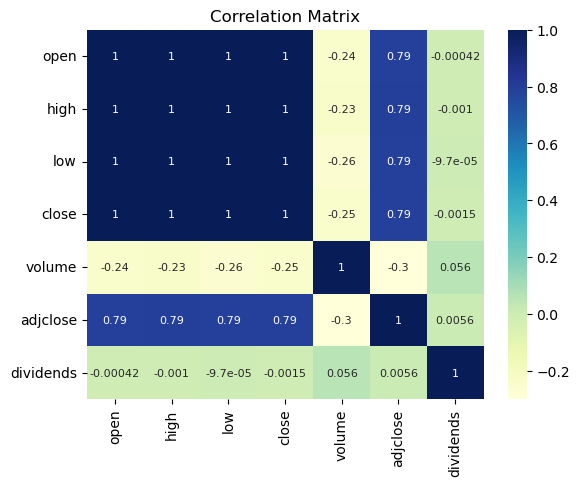

In [11]:
# Correlation matrix
corr_matrix = mbg.corr()

plt.figure()

sns.heatmap(
    data = corr_matrix,
    cmap = 'YlGnBu',
    annot = True,
    annot_kws = {'size': 8}
)

plt.title('Correlation Matrix')
plt.show()

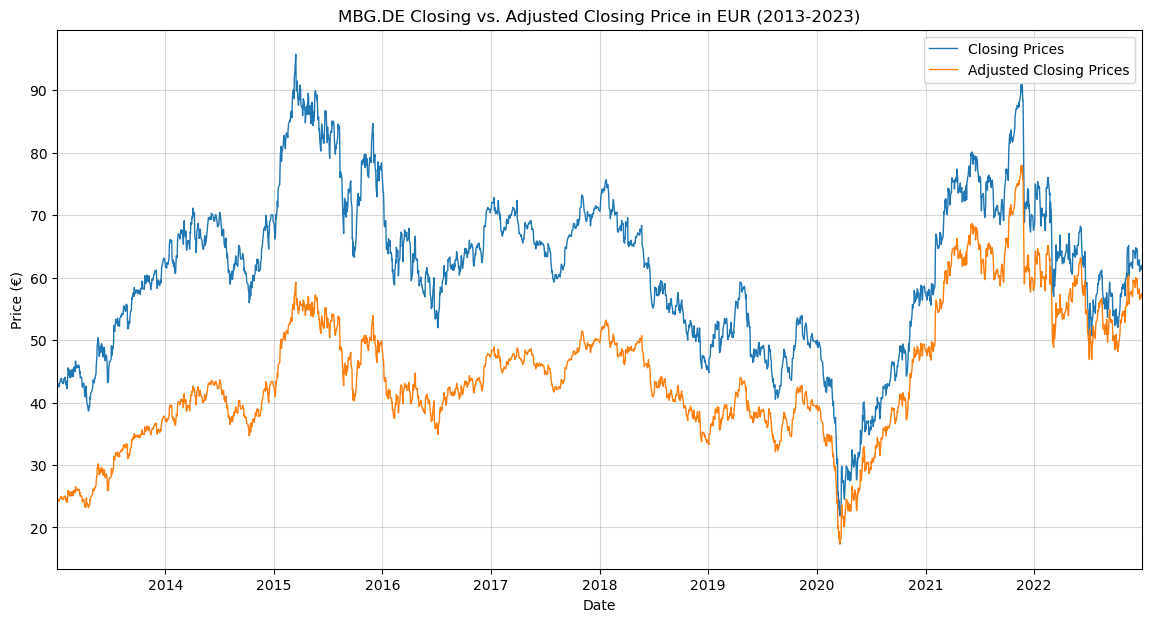

In [12]:
# Plot closing vs. adjusted closing price
plt.figure(figsize=(14, 7))

mbg['close'].plot(label='Closing Prices', linewidth=1)
mbg['adjclose'].plot(label='Adjusted Closing Prices', linewidth=1)

plt.title('MBG.DE Closing vs. Adjusted Closing Price in EUR (2013-2023)')
plt.ylabel('Price (€)')
plt.xlabel('Date')
plt.legend()
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.show()

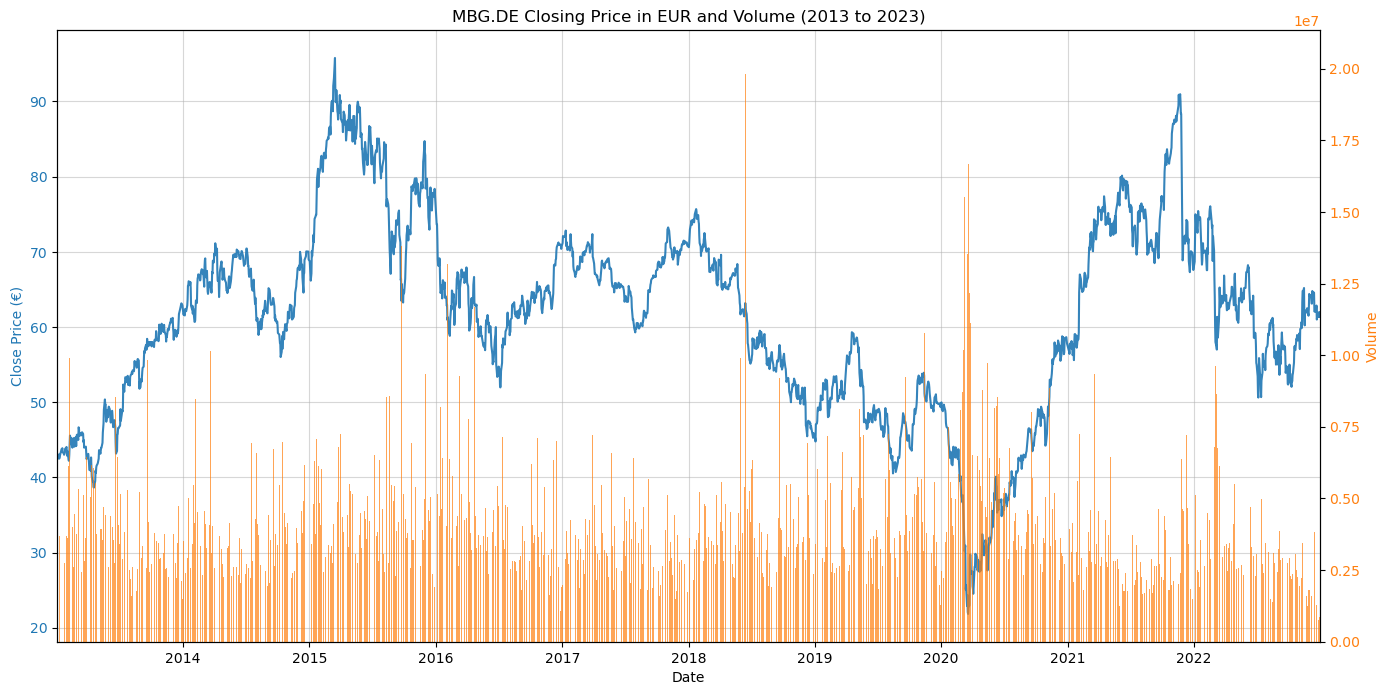

In [13]:
# Compare closing price with volume
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')

color = 'tab:blue'
ax1.set_ylabel('Close Price (€)', color=color)
ax1.plot(mbg.index, mbg['close'], color=color, alpha=0.9)
ax1.tick_params(axis='y', labelcolor=color)
ax1.margins(x=0)
ax1.grid(True, alpha=0.5)

ax2 = ax1.twinx()

color = 'tab:orange'
ax2.set_ylabel('Volume', color=color)
ax2.bar(mbg.index, mbg['volume'], color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.margins(x=0)

fig.tight_layout()
plt.title('MBG.DE Closing Price in EUR and Volume (2013 to 2023)')
plt.show()

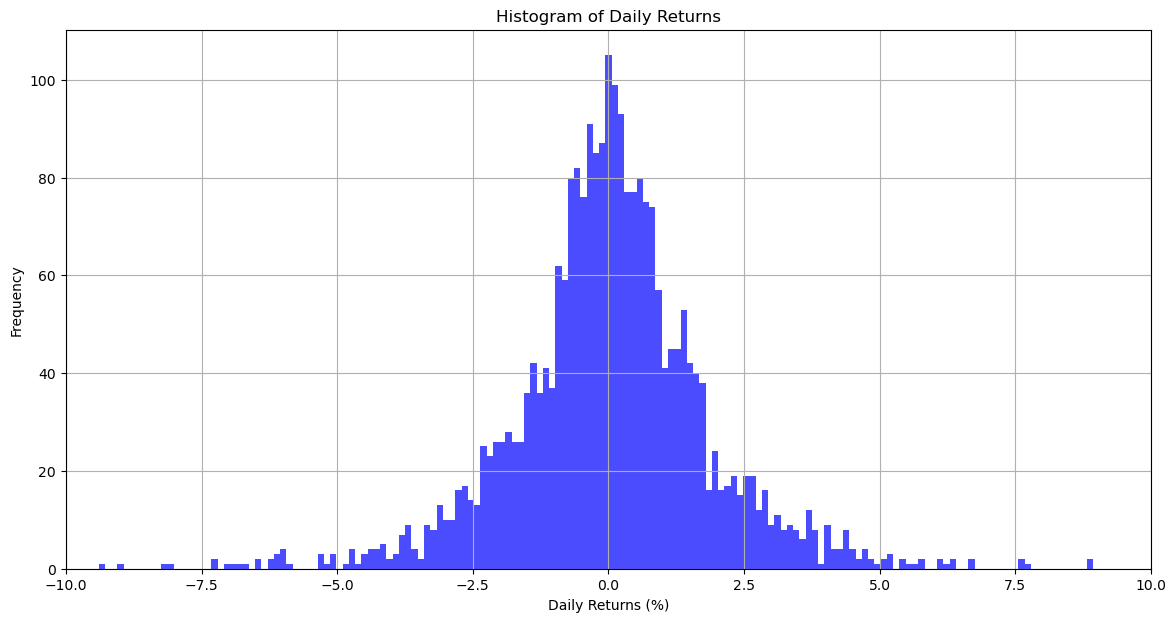

In [14]:
# Calculate daily returns as a percentage change from the previous day's close
daily_returns = mbg['close'].pct_change() * 100

plt.figure(figsize=(14, 7))
plt.hist(daily_returns.dropna(), bins=400, color='blue', alpha=0.7)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Returns (%)')
plt.ylabel('Frequency')
plt.xlim(-10, 10)
plt.grid(True)
plt.show()

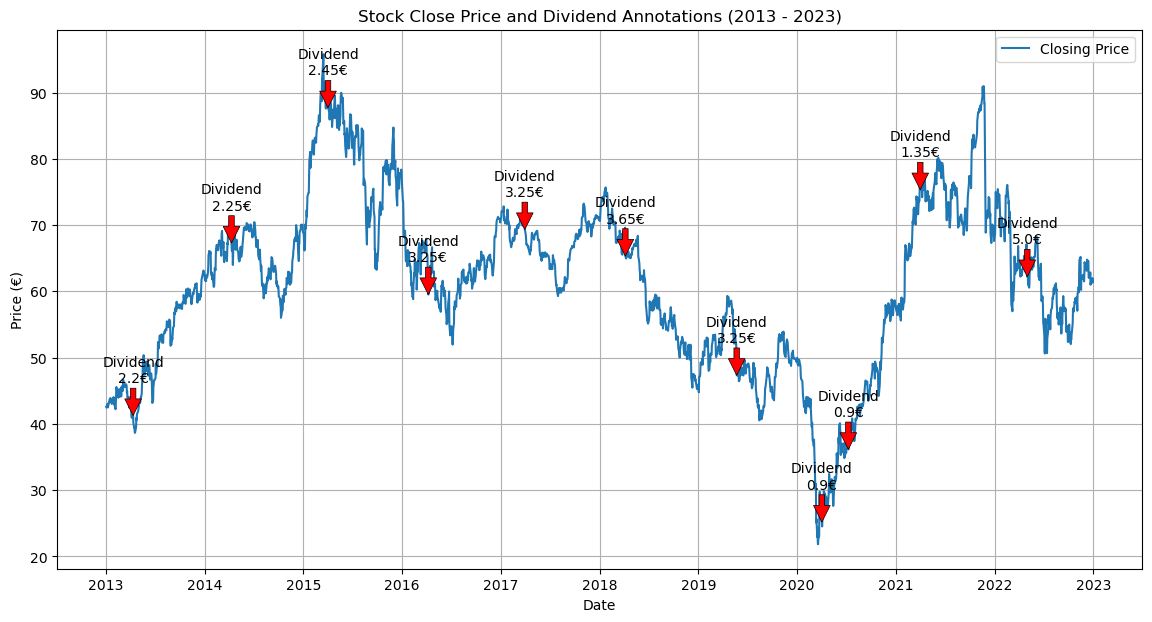

In [15]:
# Comparing dividend with closing price
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(mbg.index, mbg['close'], label='Closing Price')

for date, dividend in mbg[mbg['dividends'] > 0].iterrows():
    ax.annotate(f'Dividend\n{dividend["dividends"]}€', xy=(date, mbg.loc[date, 'close']),
                xytext=(date, mbg.loc[date, 'close'] + 5),
                arrowprops=dict(facecolor='red', linewidth=0.5),
                horizontalalignment='center')

ax.set_xlabel('Date')
ax.set_ylabel('Price (€)')
ax.set_title('Stock Close Price and Dividend Annotations (2013 - 2023)')
ax.legend()
ax.grid(True)
plt.show()

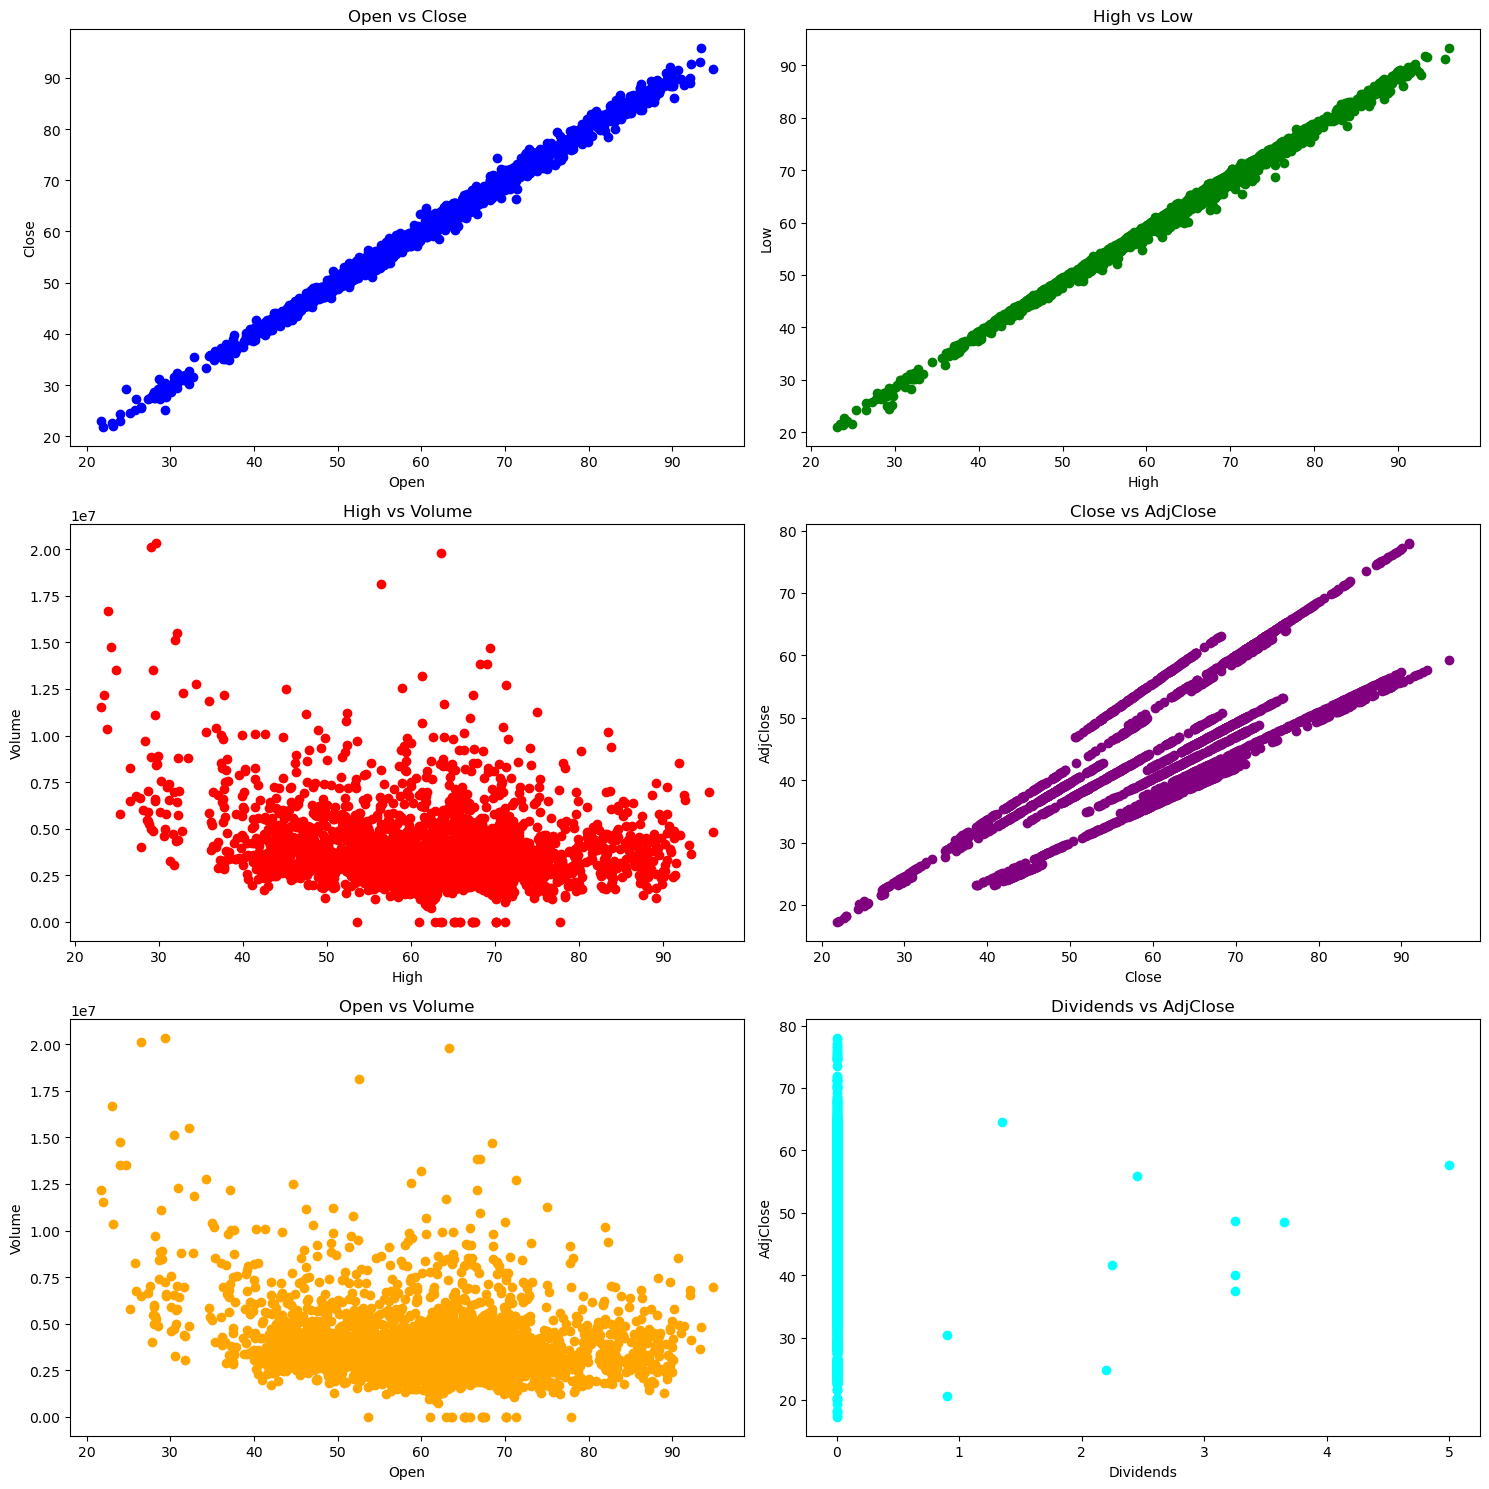

In [16]:
# Comparing different stock features as a scatter plot
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Plot open vs close
ax[0, 0].scatter(mbg['open'], mbg['close'], color='blue')
ax[0, 0].set_title('Open vs Close')
ax[0, 0].set_xlabel('Open')
ax[0, 0].set_ylabel('Close')

# Plot high vs low
ax[0, 1].scatter(mbg['high'], mbg['low'], color='green')
ax[0, 1].set_title('High vs Low')
ax[0, 1].set_xlabel('High')
ax[0, 1].set_ylabel('Low')

# Plot high vs volume
ax[1, 0].scatter(mbg['high'], mbg['volume'], color='red')
ax[1, 0].set_title('High vs Volume')
ax[1, 0].set_xlabel('High')
ax[1, 0].set_ylabel('Volume')

# Plot close vs adjclose
ax[1, 1].scatter(mbg['close'], mbg['adjclose'], color='purple')
ax[1, 1].set_title('Close vs AdjClose')
ax[1, 1].set_xlabel('Close')
ax[1, 1].set_ylabel('AdjClose')

# Plot open vs volume
ax[2, 0].scatter(mbg['open'], mbg['volume'], color='orange')
ax[2, 0].set_title('Open vs Volume')
ax[2, 0].set_xlabel('Open')
ax[2, 0].set_ylabel('Volume')

# Plot dividends vs adjclose
ax[2, 1].scatter(mbg['dividends'], mbg['adjclose'], color='cyan')
ax[2, 1].set_title('Dividends vs AdjClose')
ax[2, 1].set_xlabel('Dividends')
ax[2, 1].set_ylabel('AdjClose')

plt.tight_layout()
plt.show()

## Feature engineering

In [17]:
# Creating the price rise target variable
features = pd.DataFrame(index=mbg.index)

features['price_rise'] = np.where(mbg['close'].shift(-1) >  mbg['close'], 1, 0)

### Moving Averages and Standard deviations

In [18]:
# Calculate the moving averages and moving standard averages
windows = (3, 5, 21, 63, 126, 252)

for window in windows:
  features['{} days MA'.format(window)] = mbg['close'].shift(1).rolling(window).mean()
  features['{} days std dev'.format(window)] = mbg['close'].rolling(window).std()

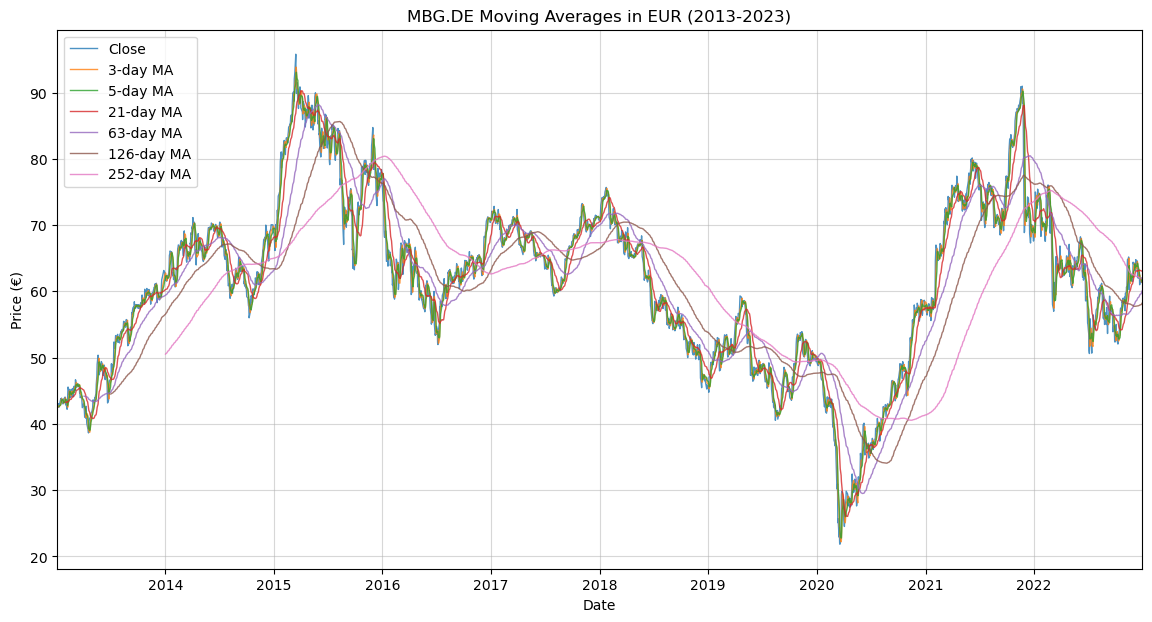

In [19]:
# Plot moving averages to close price
plt.figure(figsize=(14, 7))

mbg['close'].plot(label='Close', linewidth=1, alpha=0.8)
for window in windows:
  features['{} days MA'.format(window)].plot(label='{}-day MA'.format(window), linewidth=1, alpha=0.8)

plt.title('MBG.DE Moving Averages in EUR (2013-2023)')
plt.ylabel('Price (€)')
plt.xlabel('Date')
plt.legend()
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.show()

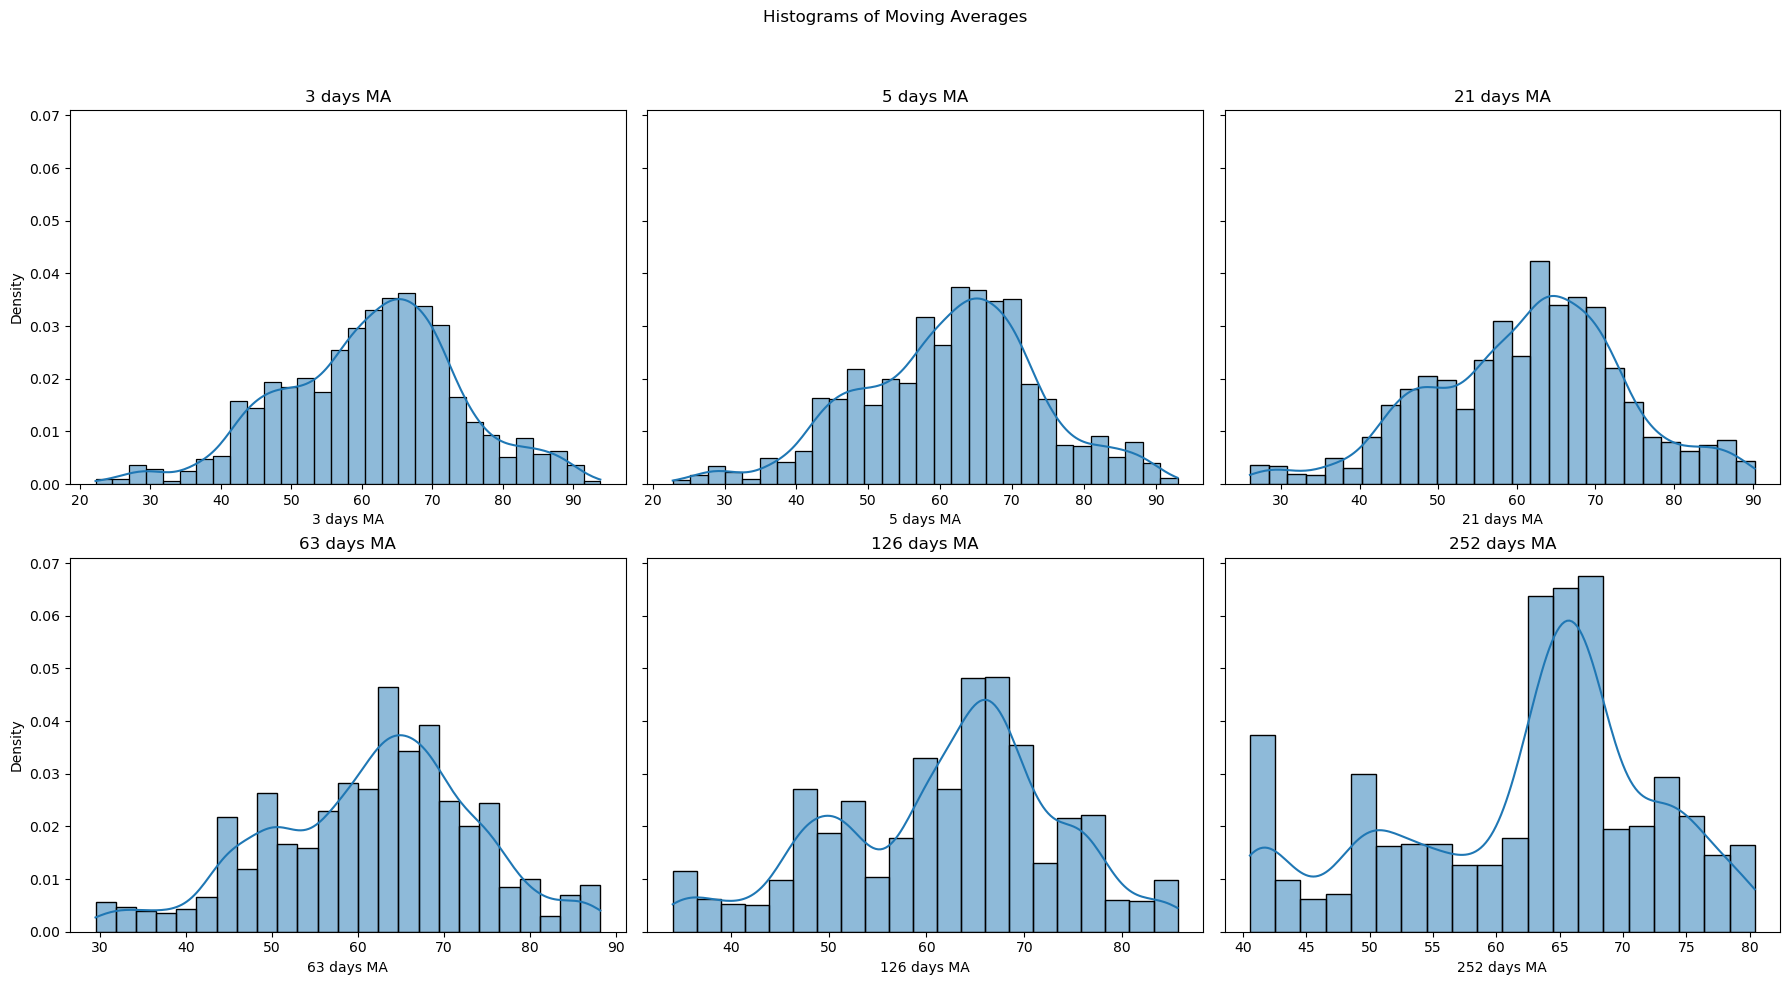

In [20]:
# Plot histograms of the moving averages
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

sns.histplot(features['3 days MA'].dropna(), ax=axes[0, 0], kde=True, stat="density")
axes[0, 0].set_title('3 days MA')

sns.histplot(features['5 days MA'].dropna(), ax=axes[0, 1], kde=True, stat="density")
axes[0, 1].set_title('5 days MA')

sns.histplot(features['21 days MA'].dropna(), ax=axes[0, 2], kde=True, stat="density")
axes[0, 2].set_title('21 days MA')

sns.histplot(features['63 days MA'].dropna(), ax=axes[1, 0], kde=True, stat="density")
axes[1, 0].set_title('63 days MA')

sns.histplot(features['126 days MA'].dropna(), ax=axes[1, 1], kde=True, stat="density")
axes[1, 1].set_title('126 days MA')

sns.histplot(features['252 days MA'].dropna(), ax=axes[1, 2], kde=True, stat="density")
axes[1, 2].set_title('252 days MA')

plt.suptitle('Histograms of Moving Averages')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

---

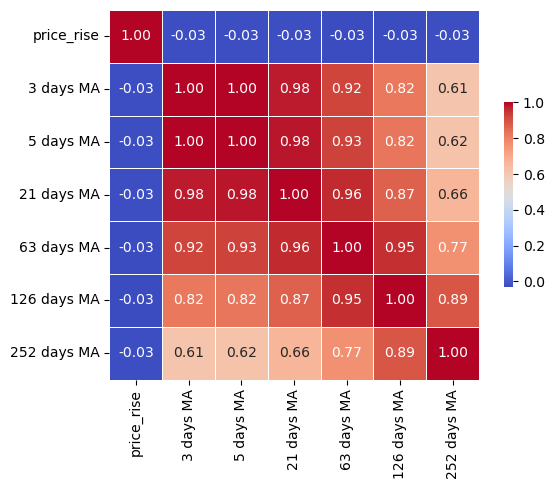

In [21]:
corr_matrix = features[['price_rise', '3 days MA', '5 days MA', '21 days MA', '63 days MA', '126 days MA', '252 days MA']].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

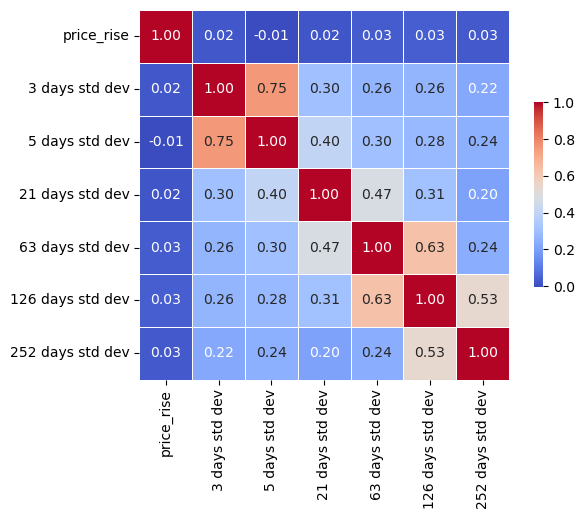

In [22]:
corr_matrix = features[['price_rise', '3 days std dev', '5 days std dev', '21 days std dev', '63 days std dev', '126 days std dev', '252 days std dev']].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Volume Indicators

In [23]:
# On-Balance Volume (OBV)
features['OBV'] = (mbg['volume'] * (~mbg['close'].diff().le(0) * 2 - 1)).cumsum()

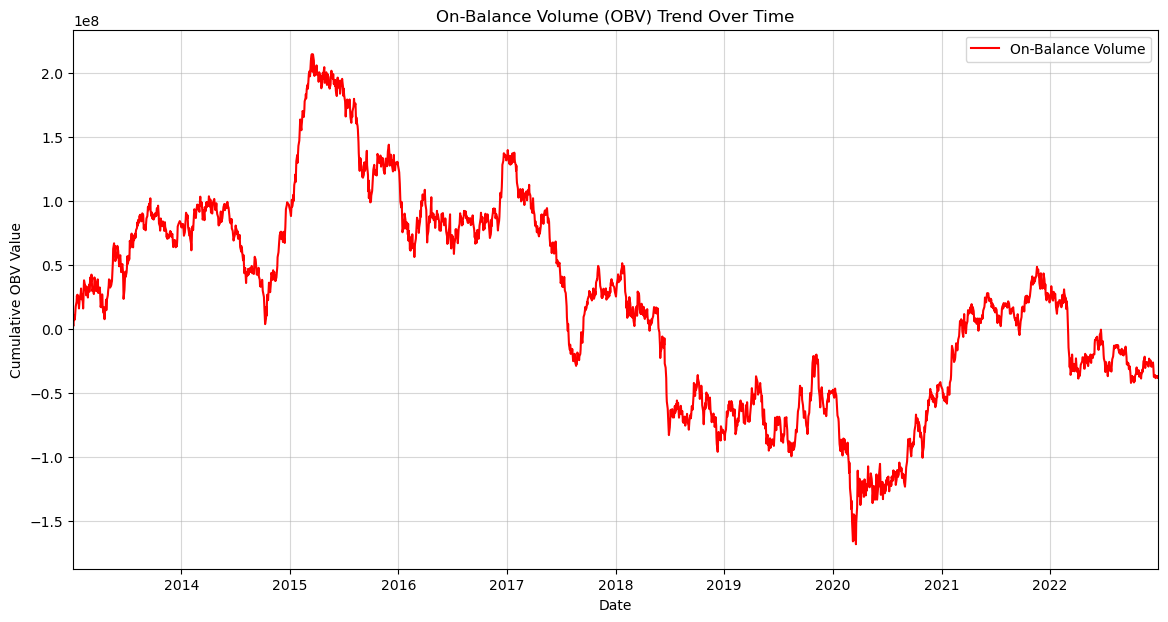

In [24]:
plt.figure(figsize=(14, 7))

plt.plot(features['OBV'], label='On-Balance Volume', color='red')

plt.title('On-Balance Volume (OBV) Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative OBV Value')
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

---

In [25]:
# Price Volume Trend (PVT)
features['PVT'] = (mbg['volume'] * (mbg['close'].pct_change())).cumsum()

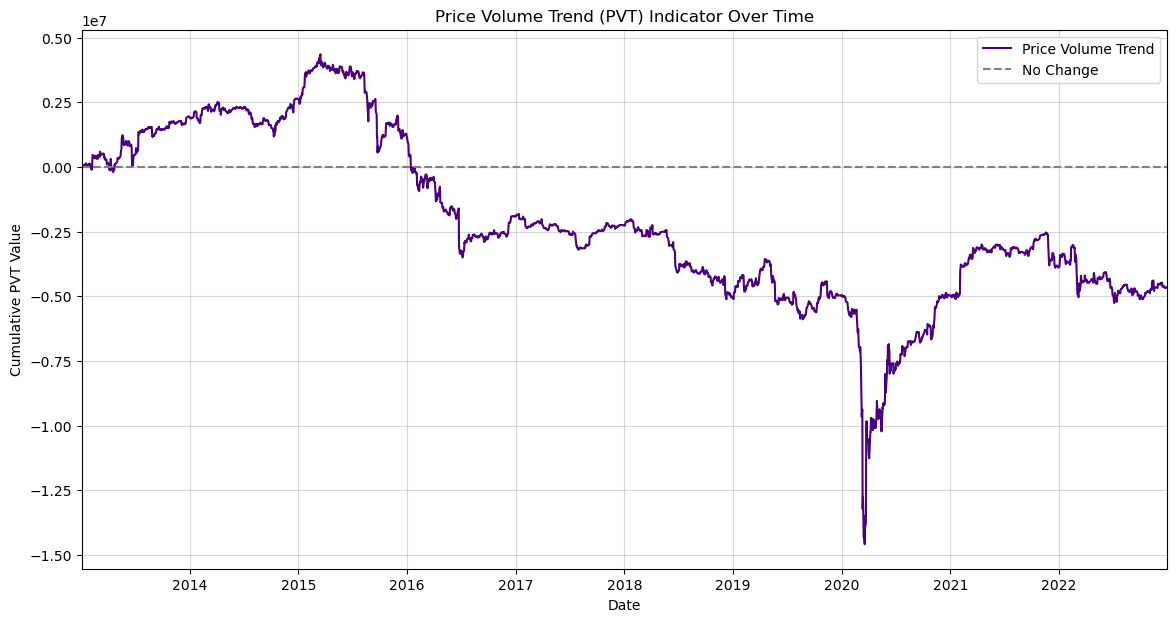

In [26]:
plt.figure(figsize=(14, 7))

plt.plot(features['PVT'], label='Price Volume Trend', color='indigo')
plt.axhline(0, color='grey', linestyle='--', label='No Change')

plt.title('Price Volume Trend (PVT) Indicator Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PVT Value')
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

---

In [27]:
# Volume Weighted Average Price (VWAP)
cumulative_tp_volume = (mbg['close'] + mbg['low'] + mbg['high']) / 3 * mbg['volume']
cumulative_volume = mbg['volume'].cumsum()
features['VWAP'] = cumulative_tp_volume.cumsum() / cumulative_volume

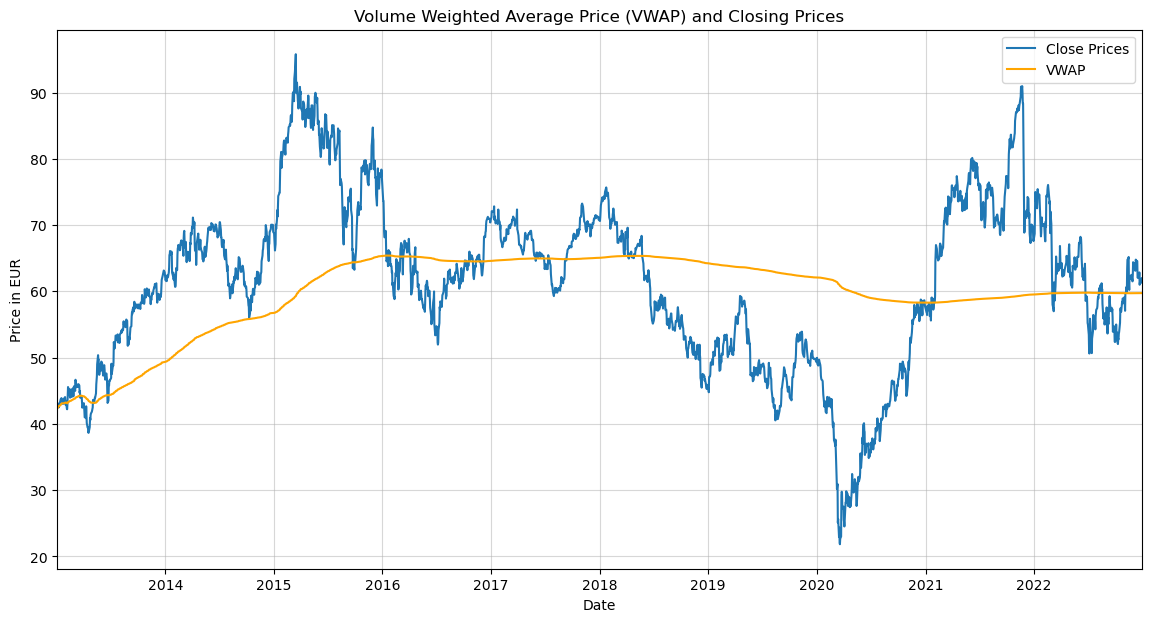

In [28]:
plt.figure(figsize=(14, 7))

plt.plot(mbg['close'], label='Close Prices')
plt.plot(features['VWAP'], label='VWAP', color='orange')

plt.title('Volume Weighted Average Price (VWAP) and Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price in EUR')
plt.grid(True, alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.show()

---

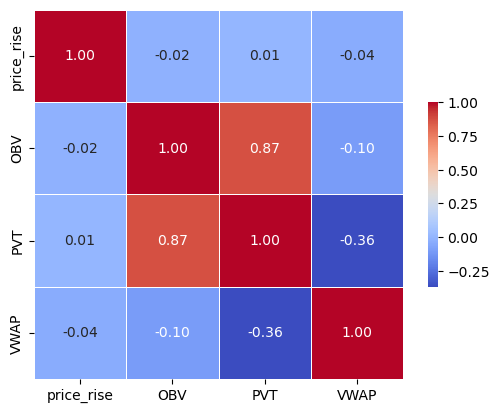

In [29]:
corr_matrix = features[['price_rise', 'OBV', 'PVT', 'VWAP']].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Momentum Indicators

In [30]:
# Relative Strength Index (RSI)
delta = mbg['close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down
features['RSI'] = 100 - (100 / (1 + rs))

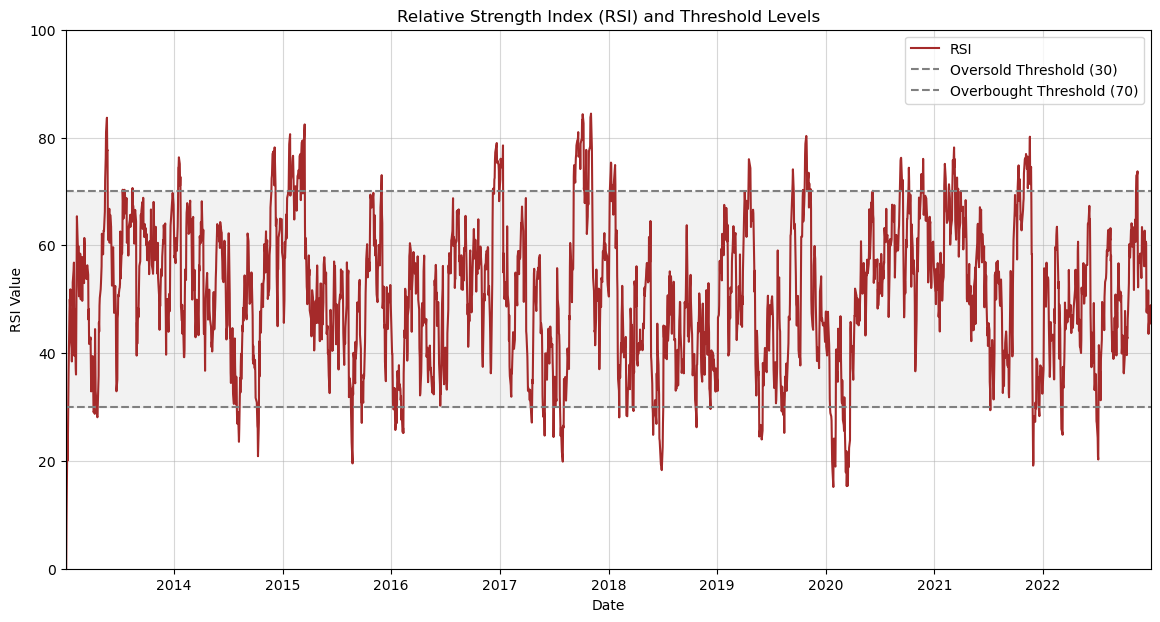

In [31]:
plt.figure(figsize=(14, 7))

plt.plot(features['RSI'], label='RSI', color='brown')
plt.axhline(30, color='grey', linestyle='--', label='Oversold Threshold (30)')
plt.axhline(70, color='grey', linestyle='--', label='Overbought Threshold (70)')
plt.fill_between(features.index, 30, 70, color='grey', alpha=0.1)

plt.title('Relative Strength Index (RSI) and Threshold Levels')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.grid(True, alpha=0.5)
plt.ylim([0, 100])
plt.margins(x=0)
plt.legend()
plt.show()

---

In [32]:
# Moving Average Convergence Divergence (MACD)
ema_12 = mbg['close'].ewm(span=12, adjust=False).mean()
ema_26 = mbg['close'].ewm(span=26, adjust=False).mean()
features['MACD'] = ema_12 - ema_26
MACD_signal_line = features['MACD'].ewm(span=9, adjust=False).mean()

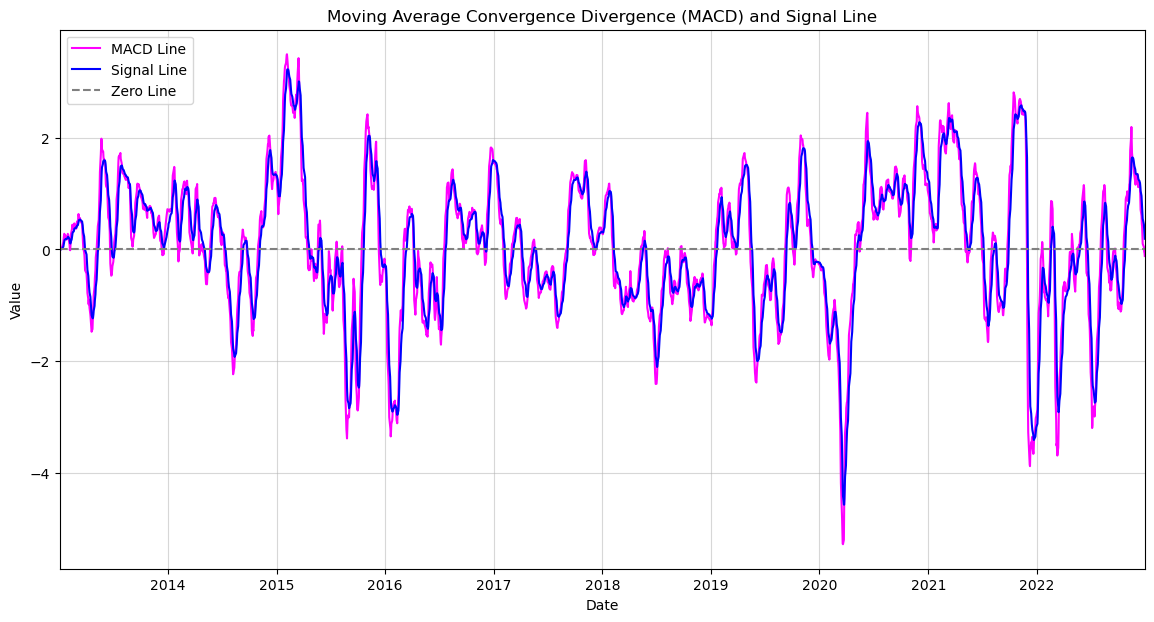

In [33]:
plt.figure(figsize=(14, 7))

plt.plot(features['MACD'], label='MACD Line', color='magenta')
plt.plot(MACD_signal_line, label='Signal Line', color='blue')
plt.axhline(0, color='grey', linestyle='--', label='Zero Line')

plt.title('Moving Average Convergence Divergence (MACD) and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.show()

---

In [34]:
# Stochastic Oscillator (%K, %D)
low_min  = mbg['low'].rolling(window=14).min()
high_max = mbg['high'].rolling(window=14).max()
features['k_percent'] = ((mbg['close'] - low_min) * 100) / (high_max - low_min)
features['d_percent'] = features['k_percent'].rolling(window=3).mean()  # SMA of K% line

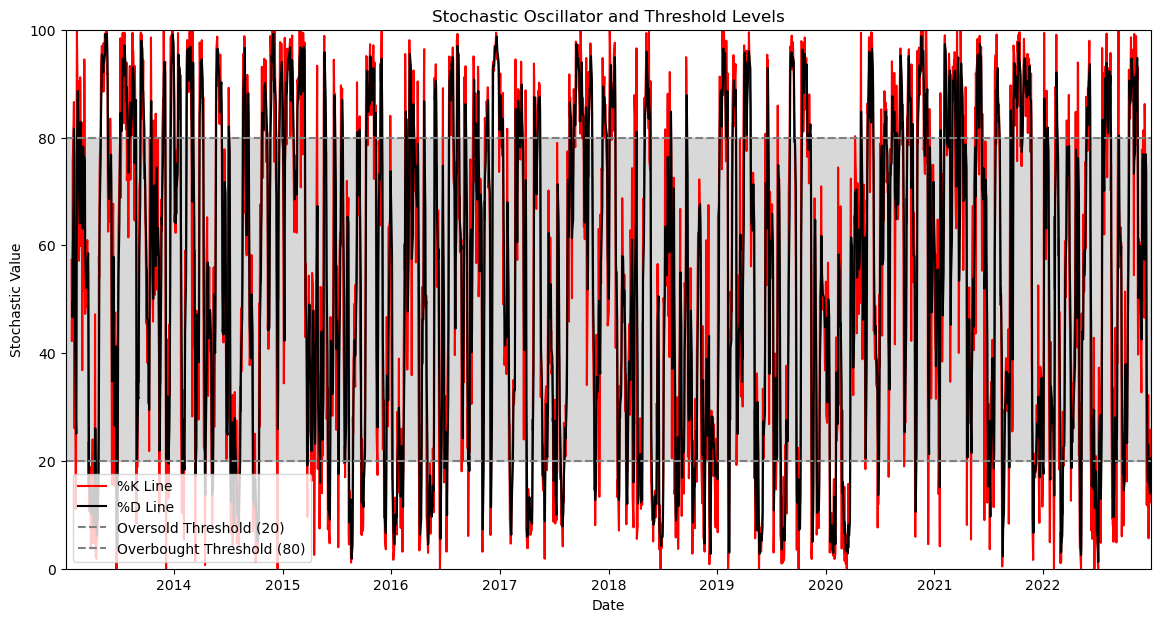

In [35]:
plt.figure(figsize=(14, 7))

plt.plot(features['k_percent'], label='%K Line', color='red')
plt.plot(features['d_percent'], label='%D Line', color='black')

plt.axhline(20, color='grey', linestyle='--', label='Oversold Threshold (20)')
plt.axhline(80, color='grey', linestyle='--', label='Overbought Threshold (80)')
plt.fill_between(features.index, 20, 80, color='grey', alpha=0.3)

plt.title('Stochastic Oscillator and Threshold Levels')
plt.xlabel('Date')
plt.ylabel('Stochastic Value')
plt.ylim([0, 100])
plt.margins(x=0)
plt.legend()
plt.show()

---

---

In [36]:
# Price Rate of Change (ROC)
features['ROC'] = mbg['close'].pct_change(periods=10) * 100

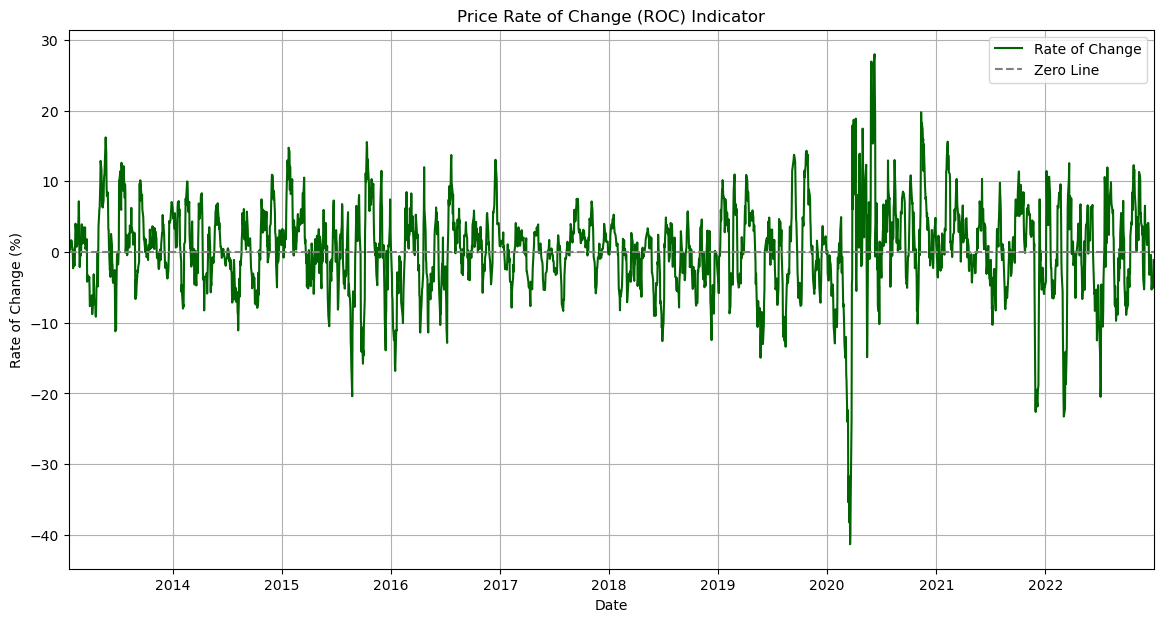

In [37]:
plt.figure(figsize=(14, 7))

plt.plot(features['ROC'], label='Rate of Change', color='darkgreen')
plt.axhline(0, color='grey', linestyle='--', label='Zero Line')

plt.title('Price Rate of Change (ROC) Indicator')
plt.xlabel('Date')
plt.ylabel('Rate of Change (%)')
plt.grid(True)
plt.margins(x=0)
plt.legend()
plt.show()

---

In [38]:
# Detrended Price Oscillator (DPO)
displaced = mbg['close'].shift(11)
features['DPO'] = mbg['close'] - displaced.rolling(window=21).mean()

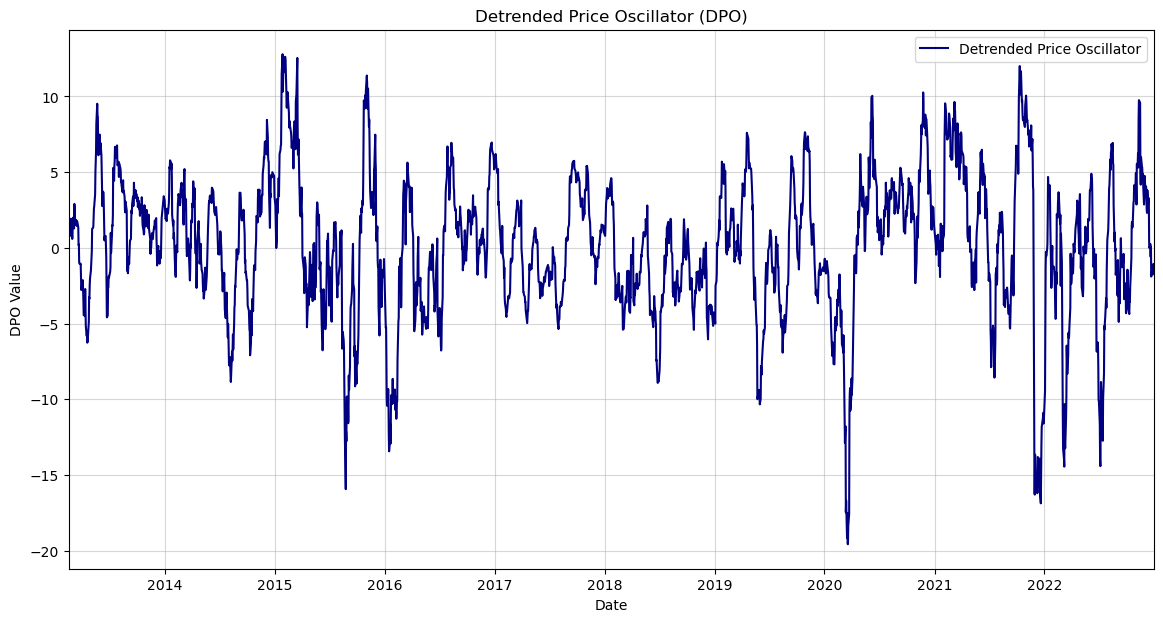

In [39]:
plt.figure(figsize=(14, 7))

plt.plot(features['DPO'], label='Detrended Price Oscillator', color='navy')

plt.title('Detrended Price Oscillator (DPO)')
plt.xlabel('Date')
plt.ylabel('DPO Value')
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

---

In [40]:
# Elder Ray Index
ema_13 = mbg['close'].ewm(span=13, adjust=False).mean()
features['bull_power'] = mbg['high'] - ema_13
features['bear_power'] = mbg['low'] - ema_13

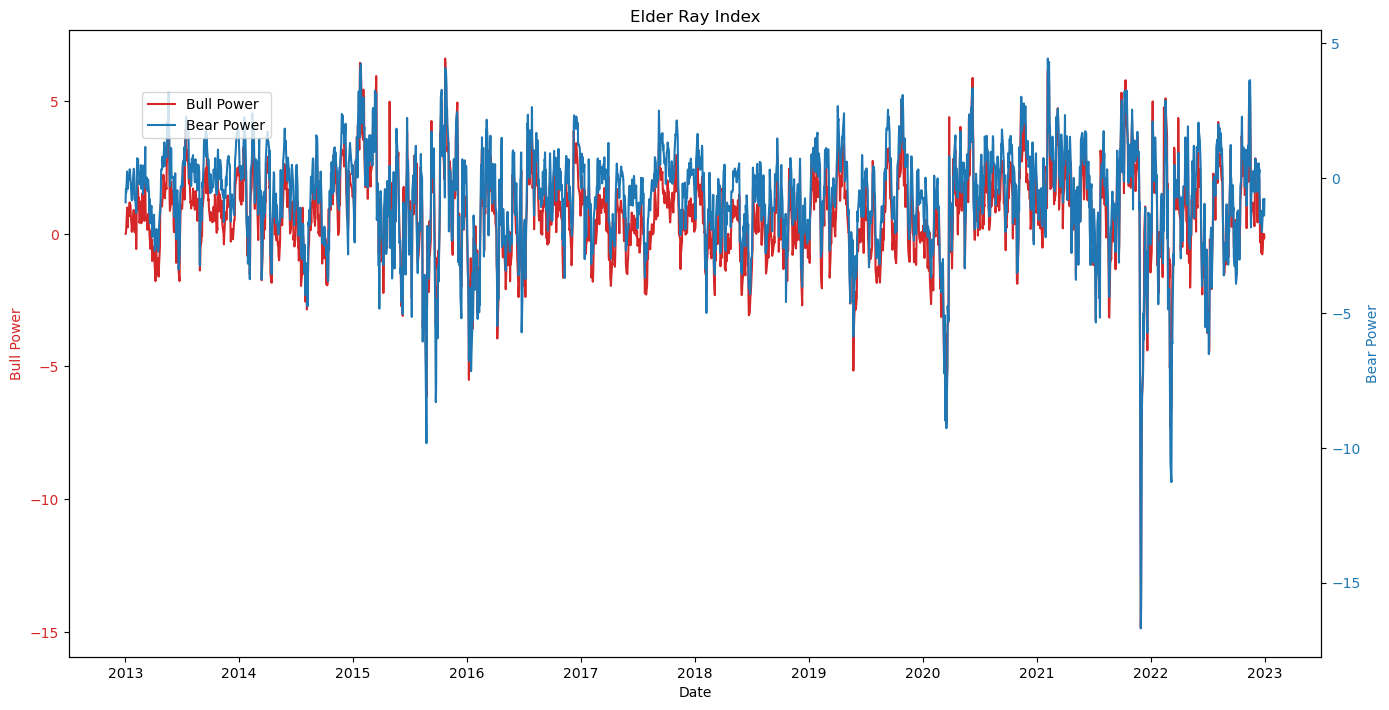

In [41]:
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bull Power', color=color)
ax1.plot(features.index, features['bull_power'], label='Bull Power', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Bear Power', color=color)  # we already handled the x-label with ax1
ax2.plot(features.index, features['bear_power'], label='Bear Power', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Elder Ray Index')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

---

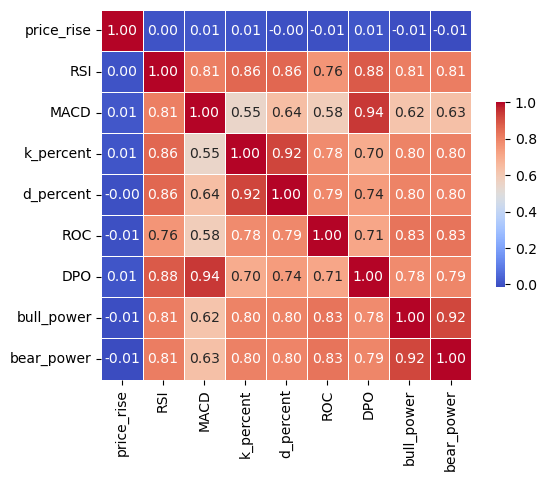

In [42]:
corr_matrix = features[['price_rise', 'RSI', 'MACD', 'k_percent', 'd_percent', 'ROC', 'DPO', 'bull_power', 'bear_power']].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

---

---

### Volatility Indicators

In [43]:
# Volatility (Historical Standard Deviation of Returns)
daily_returns = mbg['close'].pct_change()
features['volatility'] = daily_returns.rolling(window=10).std() * (252 ** 0.5)

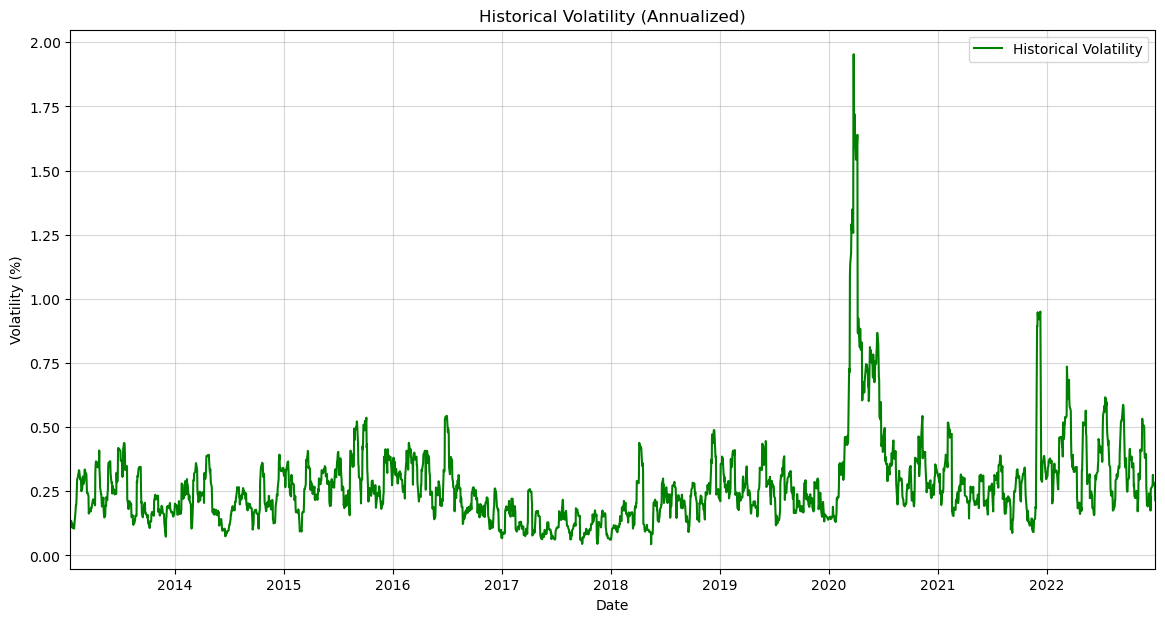

In [44]:
plt.figure(figsize=(14, 7))

plt.plot(features['volatility'], label='Historical Volatility', color='green')

plt.title('Historical Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.grid(True, alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.show()

---

In [45]:
# Average True Range (ATR)
high_prev_close = abs(mbg['high'] - mbg['close'].shift())
low_prev_close = abs(mbg['low'] - mbg['close'].shift())
daily_spread = mbg['high'] - mbg['low']
true_range = pd.concat([daily_spread, high_prev_close, low_prev_close], axis=1).max(axis=1)
features['ATR'] = true_range.rolling(window=14).mean()

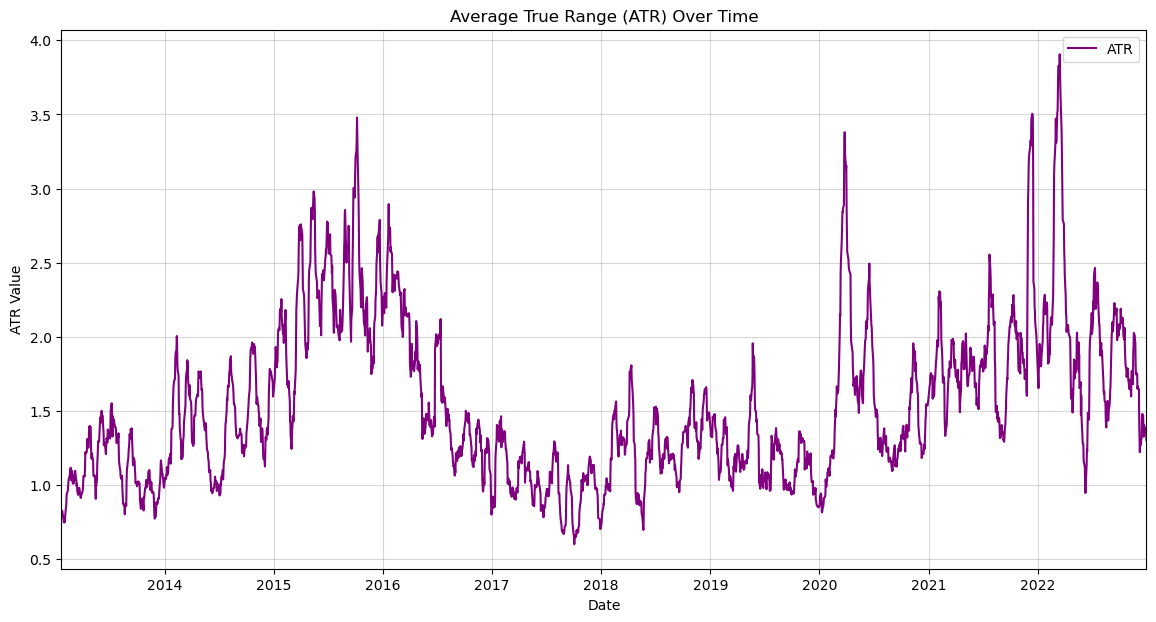

In [46]:
plt.figure(figsize=(14, 7))

plt.plot(features['ATR'], label='ATR', color='purple')

plt.title('Average True Range (ATR) Over Time')
plt.xlabel('Date')
plt.ylabel('ATR Value')
plt.margins(x=0)
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

---

In [47]:
# Bollinger Bands
rolling_window = mbg['close'].rolling(window=20)
features['upper_band'] = rolling_window.mean() + (rolling_window.std() * 2)
features['lower_band'] = rolling_window.mean() - (rolling_window.std() * 2)

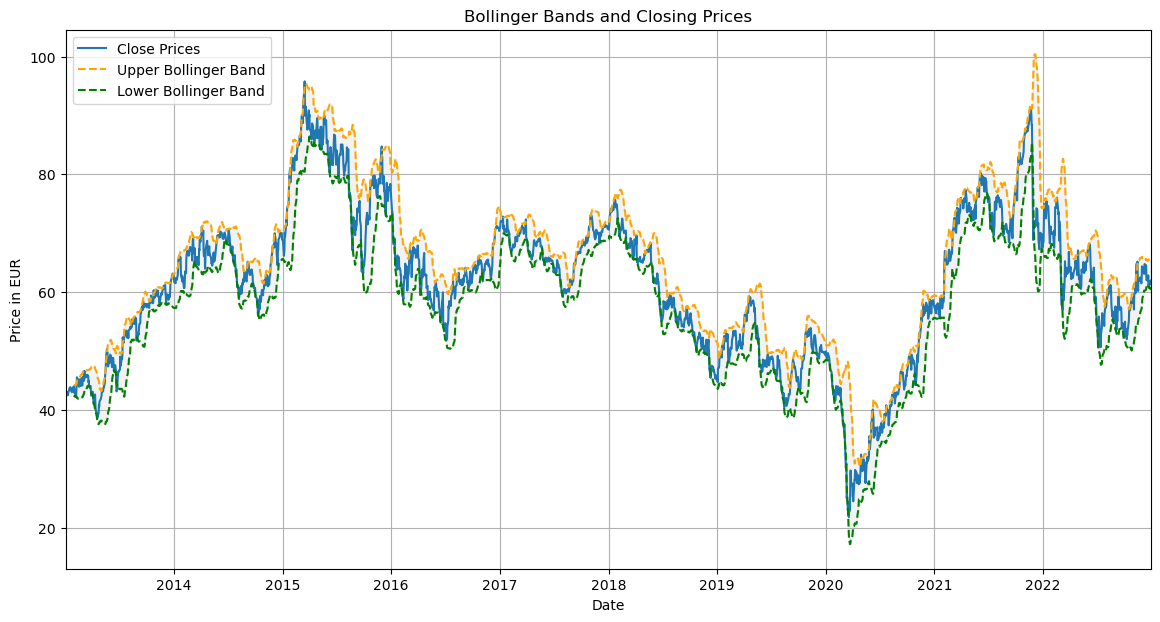

In [48]:
plt.figure(figsize=(14, 7))

plt.plot(mbg['close'], label='Close Prices')
plt.plot(features['upper_band'], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(features['lower_band'], label='Lower Bollinger Band', linestyle='--', color='green')
plt.fill_between(features.index, features['upper_band'], features['lower_band'], color='grey', alpha=0.1)

plt.title('Bollinger Bands and Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price in EUR')
plt.margins(x=0)
plt.grid(True)
plt.legend()
plt.show()

---

In [49]:
# Downloading DAX prices for beta calculation
dax_ticker = Ticker('^GDAXI')

start_date = '2013-01-01'
end_date = '2022-12-31'
interval = '1d'

dax = dax_ticker.history(
    interval = interval,
    start = start_date,
    end = end_date
    )

# Remove redundant index 'symbol' from the dataframe
dax.reset_index(level='symbol', drop=True, inplace=True)

dax.head()

open         high          low        close       volume  \
date                                                                          
2013-01-02  7689.459961  7789.939941  7689.459961  7778.779785  140345500.0   
2013-01-03  7762.129883  7777.020020  7737.979980  7756.439941   86174100.0   
2013-01-04  7740.990234  7779.669922  7727.549805  7776.370117  101577000.0   
2013-01-07  7760.009766  7767.549805  7713.419922  7732.660156  151695400.0   
2013-01-08  7710.700195  7754.379883  7683.479980  7695.830078  130425500.0   

               adjclose  
date                     
2013-01-02  7778.779785  
2013-01-03  7756.439941  
2013-01-04  7776.370117  
2013-01-07  7732.660156  
2013-01-08  7695.830078

In [50]:
# Beta calcuation against the market index DAX
mbg = mbg.merge(dax['close'], how='left', left_index=True, right_index=True, suffixes=('', '_dax'))
market_returns = mbg['close_dax'].pct_change()
stock_returns = mbg['close'].pct_change()
covariance = stock_returns.rolling(window=252).cov(market_returns)
variance = market_returns.rolling(window=252).var()
mbg.drop('close_dax', axis=1, inplace=True)
features['beta'] = covariance / variance

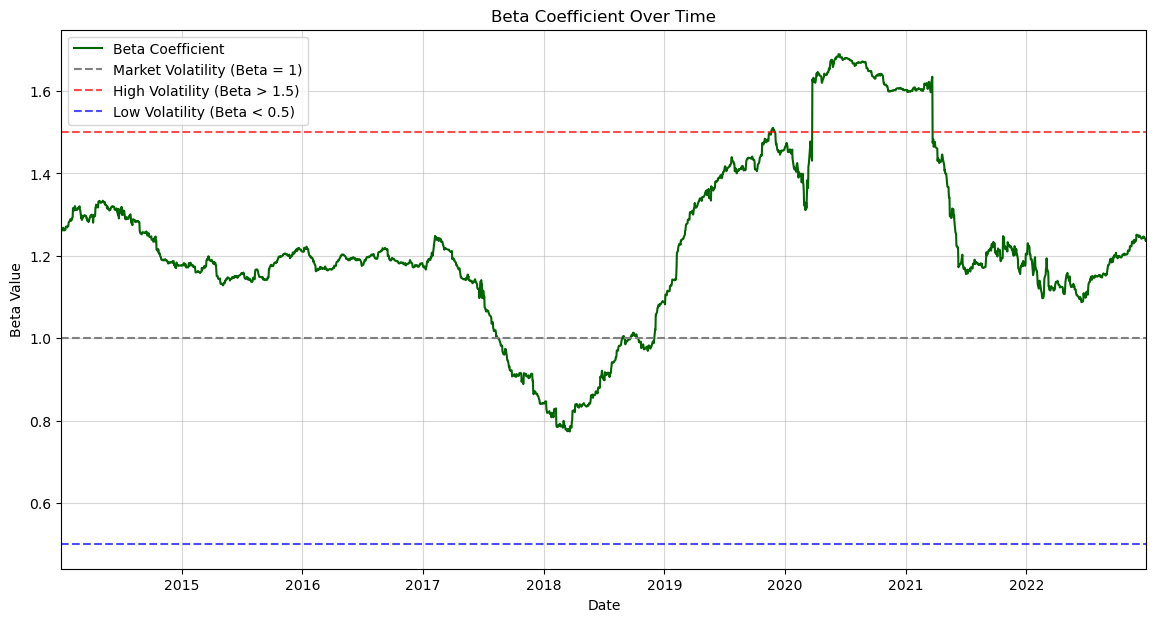

In [51]:
plt.figure(figsize=(14, 7))

plt.plot(features['beta'], label='Beta Coefficient', color='darkgreen')
plt.axhline(1, color='grey', linestyle='--', label='Market Volatility (Beta = 1)')
plt.axhline(1.5, color='red', linestyle='--', alpha=0.7, label='High Volatility (Beta > 1.5)')
plt.axhline(0.5, color='blue', linestyle='--', alpha=0.7, label='Low Volatility (Beta < 0.5)')

plt.title('Beta Coefficient Over Time')
plt.xlabel('Date')
plt.ylabel('Beta Value')
plt.grid(True, alpha=0.5)
plt.margins(x=0)
plt.legend()
plt.show()

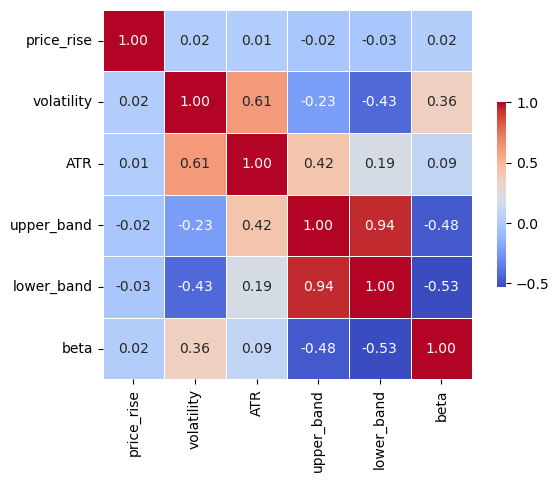

In [52]:
corr_matrix = features[['price_rise', 'volatility', 'ATR', 'upper_band', 'lower_band', 'beta']].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Combinations

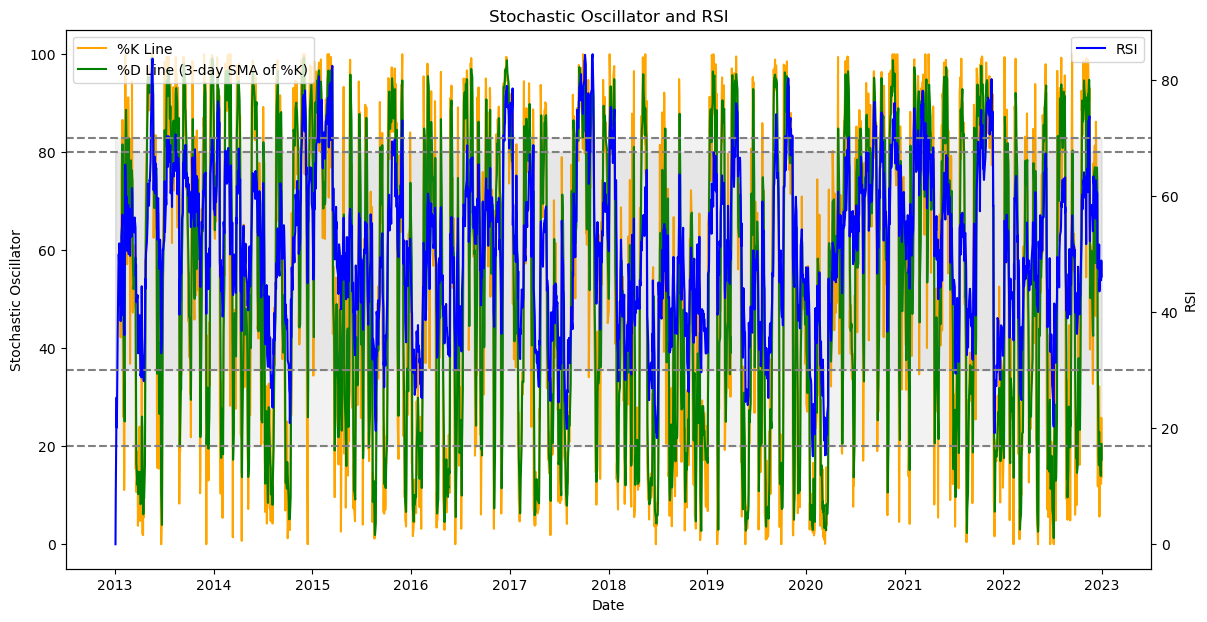

In [53]:
# Stochastic Oscillator and RSI on the same graph with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(features['k_percent'], label='%K Line', color='orange')
ax1.plot(features['d_percent'], label='%D Line (3-day SMA of %K)', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stochastic Oscillator')
ax1.axhline(20, color='grey', linestyle='--')
ax1.axhline(80, color='grey', linestyle='--')
ax1.fill_between(features.index, 20, 80, color='grey', alpha=0.1)
ax1.legend(loc='upper left')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(features['RSI'], label='RSI', color='blue')
ax2.set_ylabel('RSI')
ax2.axhline(30, color='grey', linestyle='--')
ax2.axhline(70, color='grey', linestyle='--')
ax2.fill_between(features.index, 30, 70, color='grey', alpha=0.1)
ax2.legend(loc='upper right')

plt.title('Stochastic Oscillator and RSI')
plt.show()

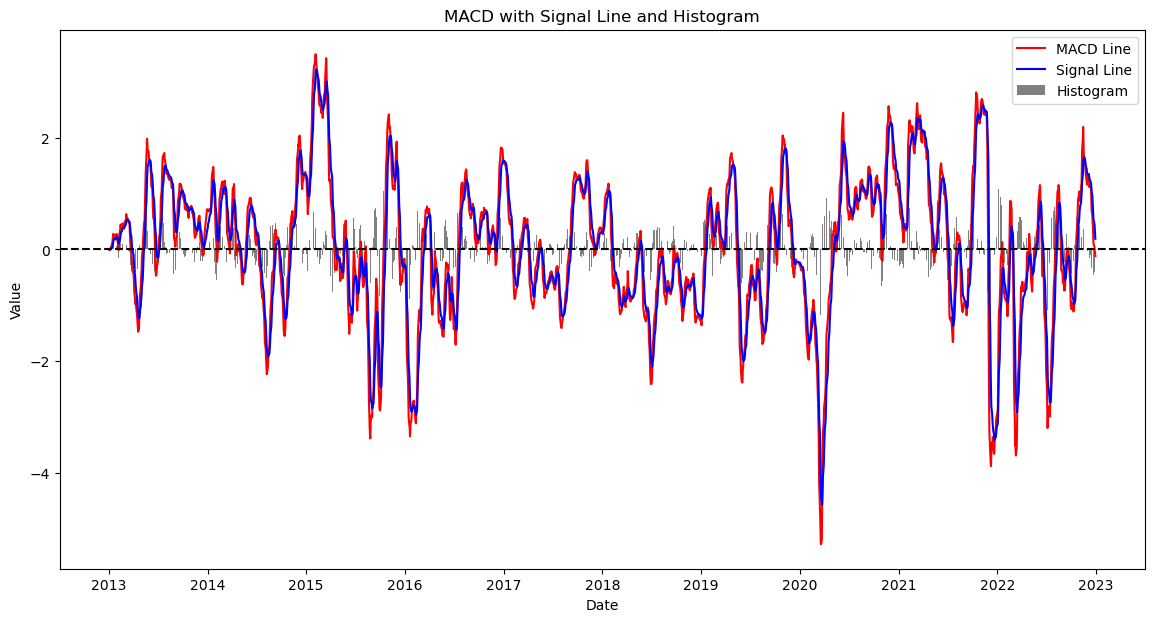

In [54]:
# MACD with its Signal Line and Histogram
plt.figure(figsize=(14, 7))
macd_signal_line = features['MACD'].ewm(span=9, adjust=False).mean()
macd_histogram = features['MACD'] - macd_signal_line
plt.plot(features['MACD'], label='MACD Line', color='red')
plt.plot(macd_signal_line, label='Signal Line', color='blue')
plt.bar(features.index, macd_histogram, label='Histogram', color='grey')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.title('MACD with Signal Line and Histogram')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

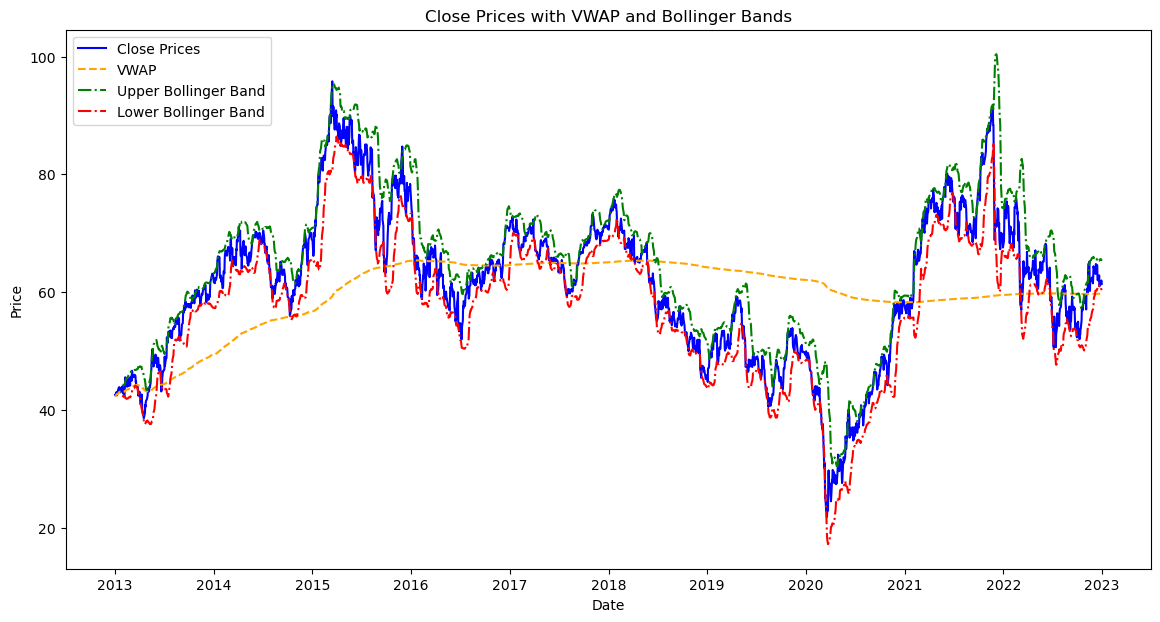

In [55]:
# Close Prices with VWAP and Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(mbg['close'], label='Close Prices', color='blue')
plt.plot(features['VWAP'], label='VWAP', color='orange', linestyle='--')
plt.plot(features['upper_band'], label='Upper Bollinger Band', color='green', linestyle='-.')
plt.plot(features['lower_band'], label='Lower Bollinger Band', color='red', linestyle='-.')
plt.title('Close Prices with VWAP and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

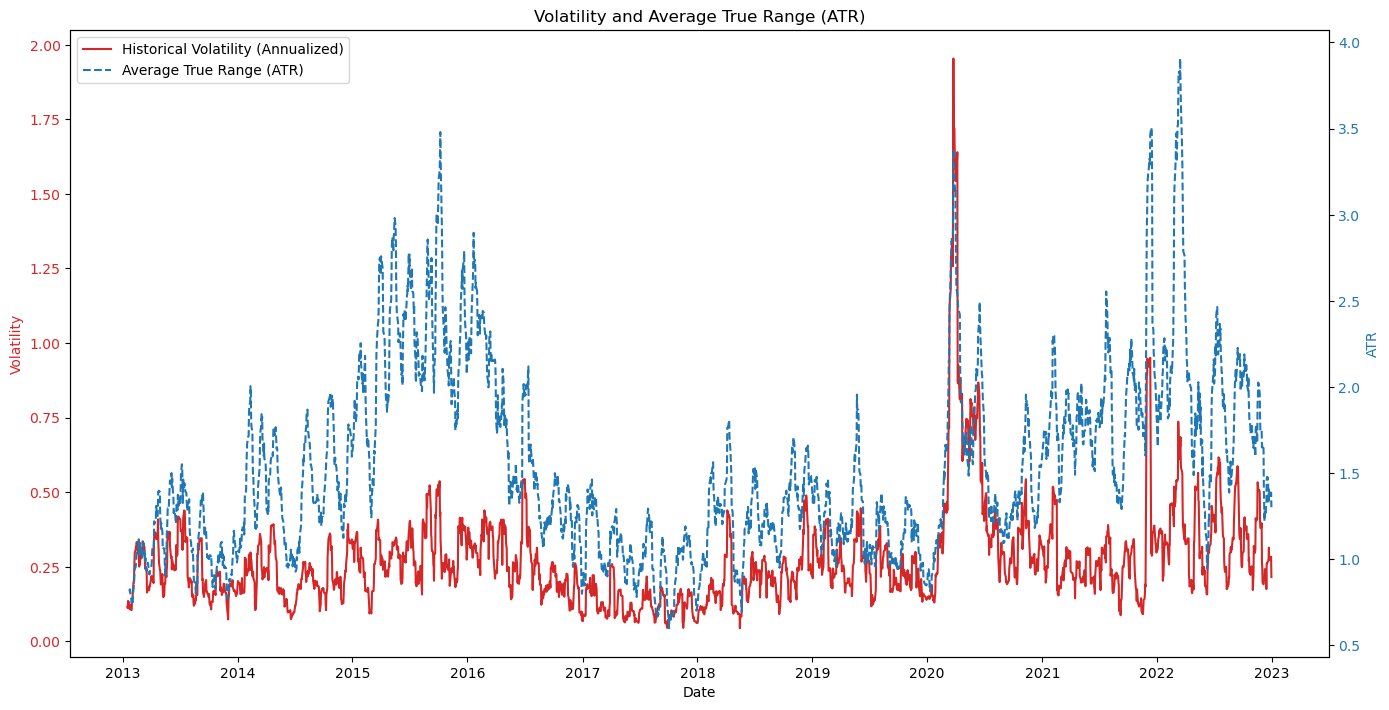

In [56]:
# Volatility and ATR
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color=color)
ax1.plot(features['volatility'], label='Historical Volatility (Annualized)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('ATR', color=color)  # we already handled the x-label with ax1
ax2.plot(features['ATR'], label='Average True Range (ATR)', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Volatility and Average True Range (ATR)')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.show()

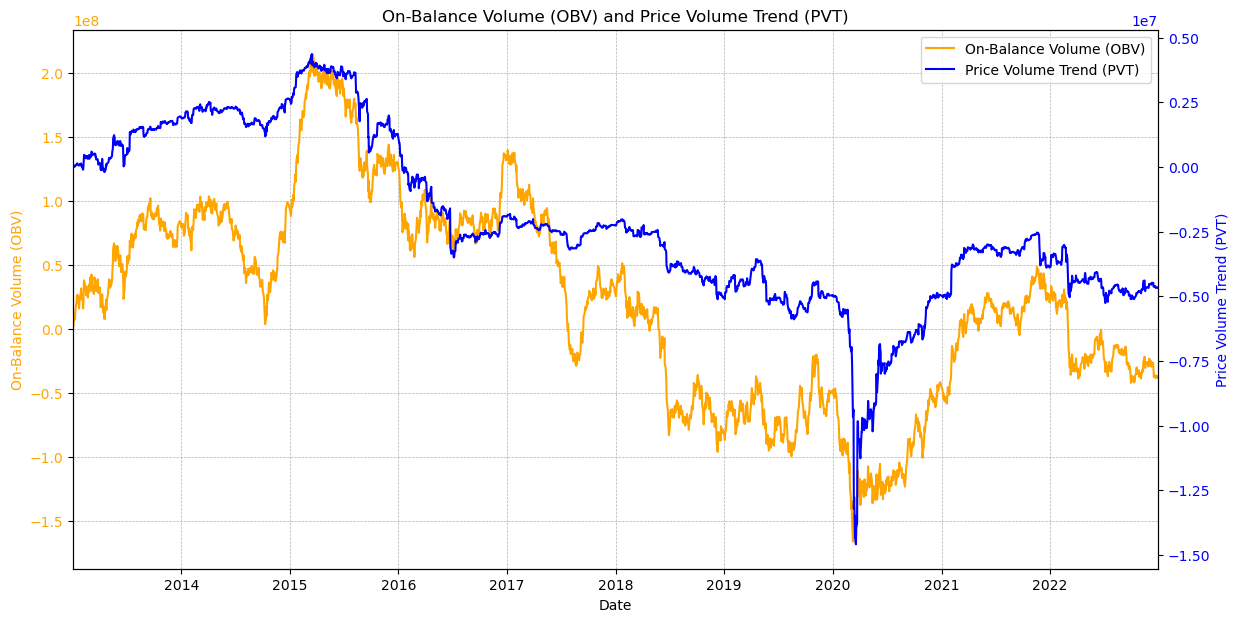

In [57]:
# OBV and PVT
fig, ax1 = plt.subplots(figsize=(14, 7))

# OBV
ax1.plot(features.index, features['OBV'], label='On-Balance Volume (OBV)', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('On-Balance Volume (OBV)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()

# PVT
ax2.plot(features.index, features['PVT'], label='Price Volume Trend (PVT)', color='blue')
ax2.set_ylabel('Price Volume Trend (PVT)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(False)

plt.title('On-Balance Volume (OBV) and Price Volume Trend (PVT)')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax1.margins(x=0)
ax2.margins(x=0)
plt.show()

---

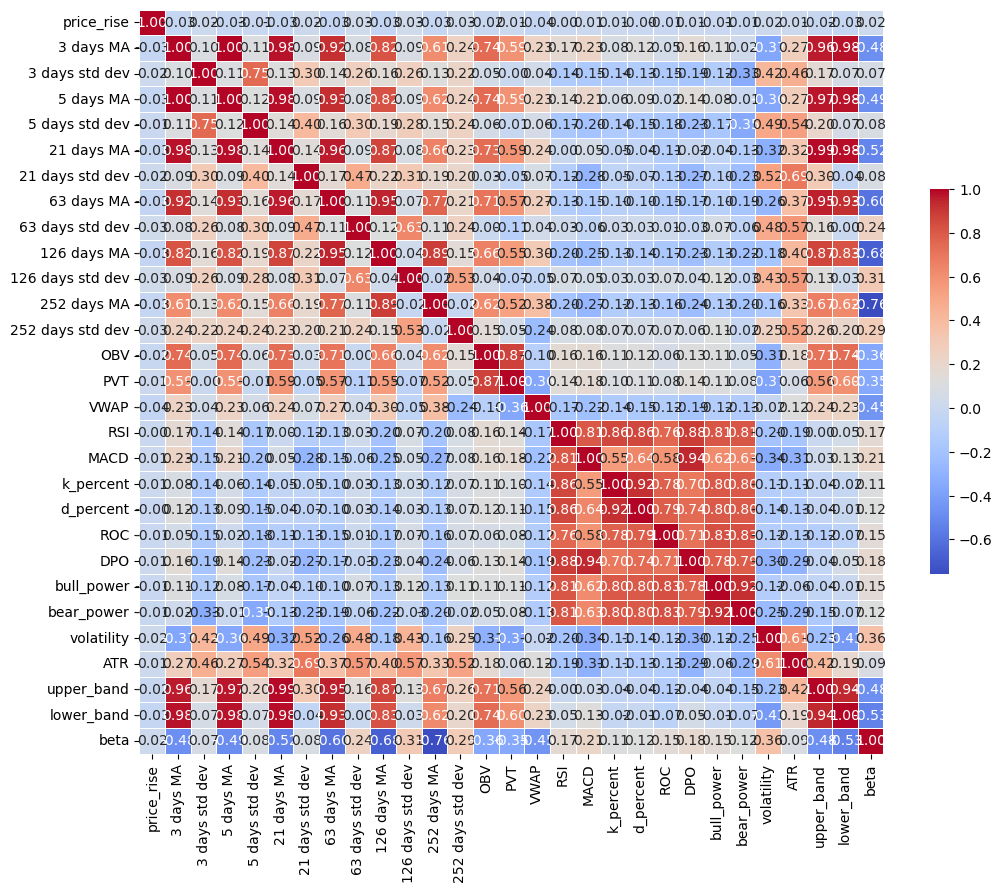

In [58]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [59]:
corr_matrix['price_rise'].sort_values(ascending=False)

price_rise          1.000000
126 days std dev    0.034598
63 days std dev     0.031746
252 days std dev    0.026113
beta                0.021778
3 days std dev      0.020671
21 days std dev     0.015392
volatility          0.015197
ATR                 0.014233
MACD                0.010197
PVT                 0.007065
k_percent           0.006256
DPO                 0.005407
RSI                 0.003035
d_percent          -0.004223
ROC                -0.005554
5 days std dev     -0.005981
bull_power         -0.008457
bear_power         -0.014548
OBV                -0.016022
upper_band         -0.022024
252 days MA        -0.025099
5 days MA          -0.026207
21 days MA         -0.026928
3 days MA          -0.026976
lower_band         -0.028121
126 days MA        -0.030739
63 days MA         -0.031706
VWAP               -0.036884
Name: price_rise, dtype: float64

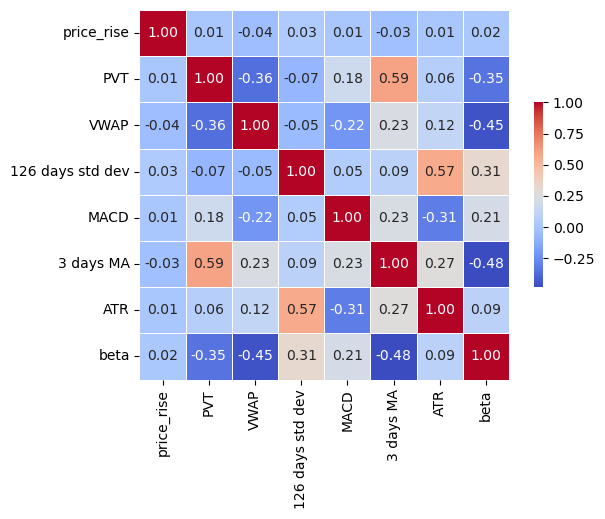

In [60]:
corr_matrix = features[['price_rise', 'PVT', 'VWAP', '126 days std dev', 'MACD', '3 days MA', 'ATR', 'beta']].corr()

plt.figure()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Model creation

In [61]:
# Clean up rows with empy values
features.dropna(inplace=True)

features.head()

price_rise  3 days MA  3 days std dev  5 days MA  5 days std dev  \
date                                                                           
2014-01-02           1  62.783334        0.803638  62.188000        0.674411   
2014-01-03           0  62.566668        0.699739  62.346001        0.674411   
2014-01-06           1  62.093334        0.095393  62.346001        0.766701   
2014-01-07           0  61.640001        0.451775  62.194001        0.584663   
2014-01-08           0  61.890001        0.451774  62.044001        0.376470   

            21 days MA  21 days std dev  63 days MA  63 days std dev  \
date                                                                   
2014-01-02   60.280000         1.438064   59.421111         1.289229   
2014-01-03   60.305715         1.463340   59.479048         1.297601   
2014-01-06   60.338572         1.480191   59.544286         1.306267   
2014-01-07   60.364286         1.535658   59.600476         1.323040   
2014-01-08   60.420476         1.579036   59.679365         1.343020   

            126 days MA  ...  d_percent       ROC       DPO  bull_power  \
date                     ...                                              
2014-01-02    56.568294  ...  86.149366  4.704484  1.906192    2.565285   
2014-01-03    56.686071  ...  74.786009  5.143929  1.947619    1.313102   
2014-01-06    56.803333  ...  64.107142  3.272362  1.770477    1.191227   
2014-01-07    56.902222  ...  68.571426  5.494505  2.586668    1.183912   
2014-01-08    57.020317  ...  71.428565  4.361682  2.425713    1.097638   

            bear_power  volatility       ATR  upper_band  lower_band      beta  
date                                                                            
2014-01-02    0.565285    0.201843  1.028572   63.199579   57.338421  1.262602  
2014-01-03    0.233100    0.198515  1.050000   63.292064   57.318937  1.261986  
2014-01-06    0.241230    0.193979  1.040714   63.332025   57.310976  1.262160  
2014-01-07   -0.076090    0.190668  1.065714   63.587806   57.303194  1.268289  
2014-01-08    0.437638    0.194633  1.064286   63.780482   57.397518  1.266498  

[5 rows x 29 columns]

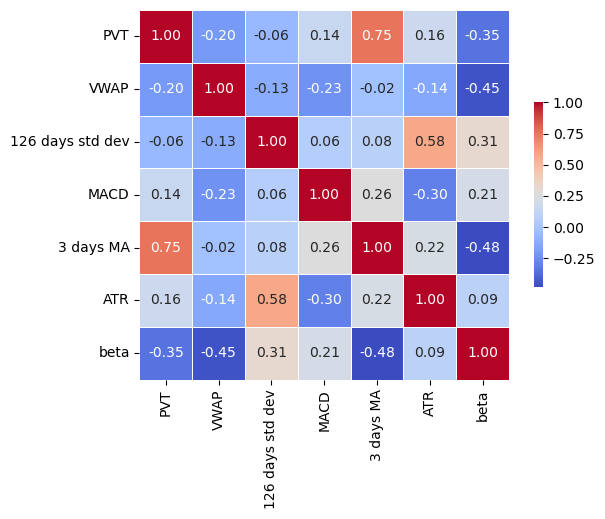

In [63]:
corr_matrix = X.corr()

plt.figure()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [62]:
X = features[['PVT', 'VWAP', '126 days std dev', 'MACD', '3 days MA', 'ATR', 'beta']]
y = features['price_rise']

In [64]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [65]:
# Fit on training data and transform both training and test data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

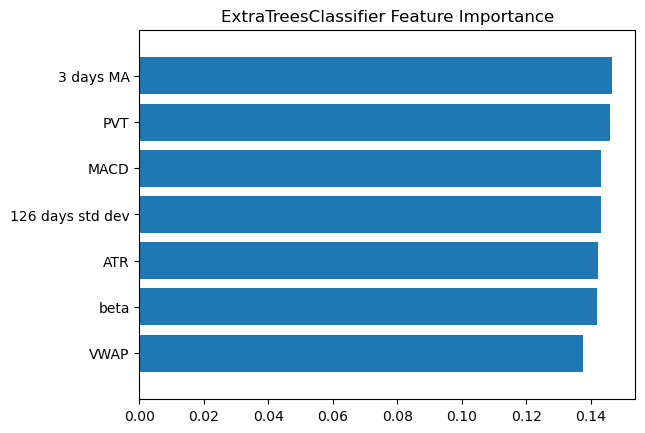

In [66]:
classifier = ExtraTreesClassifier(n_estimators=100, random_state=101)

classifier.fit(X_train_scaled, y_train)

feature_names = X_train.columns
importance = classifier.feature_importances_
indices = np.argsort(importance)

plt.figure()
plt.title("ExtraTreesClassifier Feature Importance")
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.ylim([-1, len(indices)])
plt.show()

In [67]:
# Initialize the Logistic Regression model
#log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       236
           1       0.49      0.57      0.52       221

    accuracy                           0.50       457
   macro avg       0.50      0.50      0.50       457
weighted avg       0.50      0.50      0.50       457

Accuracy: 0.5010940919037199


In [68]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print ("Logistic Regression -> cross validation accuracy (neg_mean_absolute_error): mean = %0.4f \
std = %0.4f" % (np.mean(cv_scores), np.std(cv_scores)))

Logistic Regression -> cross validation accuracy (neg_mean_absolute_error): mean = 0.5033 std = 0.0085


In [69]:
pipeline = make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=100, random_state=101))

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print ("Extra Tree Classifier -> cross validation accuracy (neg_mean_absolute_error): mean = %0.4f \
std = %0.4f" % (np.mean(scores), np.std(scores)))

Extra Tree Classifier -> cross validation accuracy (neg_mean_absolute_error): mean = 0.5015 std = 0.0058


## Evaluation

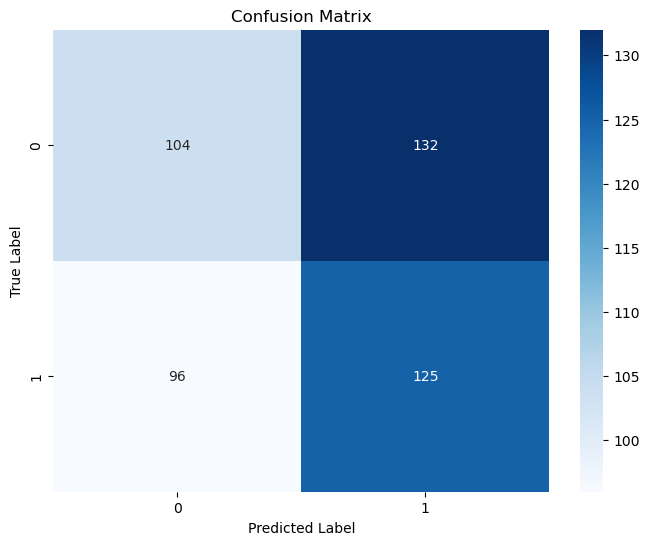

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

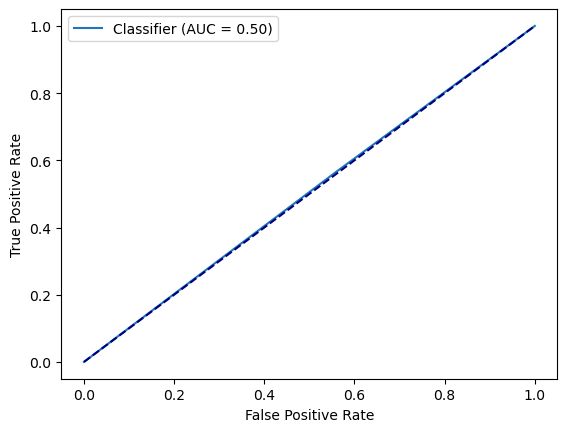

In [71]:
log_disp = RocCurveDisplay.from_predictions(y_test, y_pred_log)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Strategies

In [80]:
features['y_pred'] = np.NaN
features.iloc[(len(features) - len(y_pred_log)):,-1] = y_pred_log
trade_dataset = features.dropna()

In [74]:
trade_dataset['tomorrows_returns'] = 0.
trade_dataset['tomorrows_returns'] = np.log(mbg['close']/mbg['close'].shift(1))
trade_dataset['tomorrows_returns'] = trade_dataset['tomorrows_returns'].shift(-1)

In [75]:
trade_dataset['strategy_returns'] = 0.
trade_dataset['strategy_returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['tomorrows_returns'], - trade_dataset['tomorrows_returns'])

In [76]:
trade_dataset['cumulative_market_returns'] = np.cumsum(trade_dataset['tomorrows_returns'])
trade_dataset['cumulative_strategy_returns'] = np.cumsum(trade_dataset['strategy_returns'])

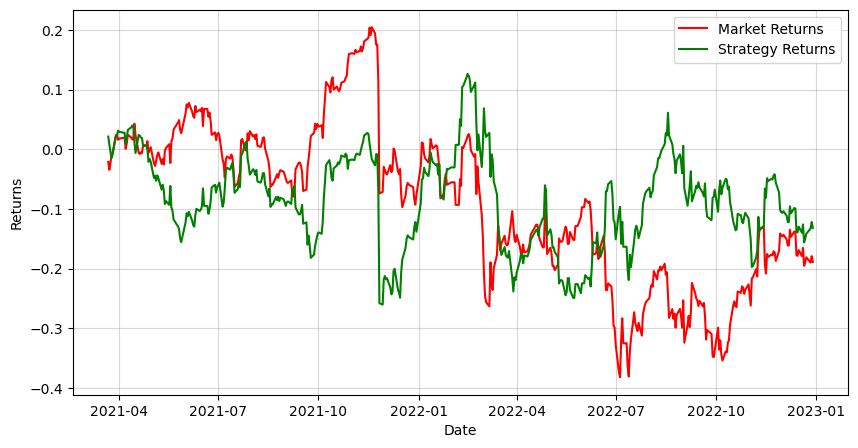

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['cumulative_market_returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['cumulative_strategy_returns'], color='g', label='Strategy Returns')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()